<details>
<summary>Table of Contents</summary>

- [MinMax Scaler (0, 1)](#minmax-scaler-0-1)
  - [1. Informer results](#1-informer-results)
  - [2. PatchTST results](#2-patchtst-results)
  - [3. Plot Informer errors](#3-plot-informer-errors)
  - [4. Plot PatchTST errors](#4-plot-patchtst-errors)
- [MinMax Scaler (0, 5)](#minmax-scaler-0-5)
  - [1. Informer](#1-informer)
  - [2. PatchTST](#2-patchtst)
  - [3. Informer errors](#3-informer-errors)
  - [4. PatchTST errors](#4-patchtst-errors)

</details>


Here we perform a check on DE dataset to confirm choice of loss function and scaler for our data.

We can use now "ReLU" activation function due to MinMax Scaler.


In [4]:
import os
import pandas as pd
import subprocess
import shutil
from utils.helper import extract_metrics_from_output, convert_results_into_df
from utils.error_analysis import plot_error_results

# MinMax Scaler (0, 1)

Please note, we dynamically overwrire "results_loss_scaled" and "results_loss_unscaled" because each of them has a weight of 1 GB. All important info is above on the plots, so we basically do not need them anymore. If you want to save them, put them in another directory!

With BS 1036, ReLU - results are bad. (as twice as bad as with 32!)

## 1. Informer results

In [2]:
# Paths to files and data
data_path = os.getcwd() + "/datasets/"

script_path = "./PatchTST-main/PatchTST_supervised/run_longExp.py"

# Arguments that will be used also for file names
model = "Informer"
dataset = 'DE_data.csv'
losses = ["MSE", "RMSE", "MAE"]
country = dataset[:2]

log_dir = f"logs/loss_choice/min_max_0_1_relu"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

log_file_path = f"{log_dir}/{model}_{country}.log"

In [12]:
# Dynamic variables
pred_lens = ["24", "96", "168"]
seq_len = "96"
lr = "0.0001"
itr = 2  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Lists to store the results
informer_results_scaled, informer_results_unscaled = [], []

# Log file
with open(log_file_path, "w") as log_file:
    for loss in losses:
        statement_1 = f"\n=== Starting experiments for loss function: {loss} ===\n"
        log_file.write(statement_1)
        print(statement_1)  # Print to .ipynb output cell

        for pred_len in pred_lens:
            statement_2 = f"\n=== Starting experiments for pred_len: {pred_len} ===\n"
            log_file.write(statement_2)
            print(statement_2) 
            model_id = f"{country}_{seq_len}_{pred_len}_loss_choice_for_{country}"

            # Arguments for the command
            command = f"""
            python {script_path} \
              --random_seed 2021 \
              --is_training 1 \
              --root_path "{data_path}" \
              --data_path "{dataset}" \
              --model_id {model_id} \
              --model "{model}" \
              --data "custom" \
              --features M \
              --seq_len {seq_len} \
              --label_len 5 \
              --pred_len {pred_len} \
              --e_layers 2 \
              --d_layers 1 \
              --factor 5 \
              --enc_in 5 \
              --dec_in 5 \
              --c_out 5 \
              --des 'Exp' \
              --train_epochs 10 \
              --patience 3 \
              --overlapping_windows \
              --inverse \
              --loss_fnc "{loss}" \
              --itr {itr} --batch_size 32 --learning_rate "{lr}"
            """

            # Run the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            # Capture the output in real-time
            output = []
            for line in process.stdout:
                output.append(line)
                print(line, end='')  # Print in the .ipynb cell
                log_file.write(line)  # Write to the log file

            # Wait for the process to complete
            process.wait()
            
            # Delete the checkpoints folder and all its contents
            shutil.rmtree('./checkpoints' )

            # Extract metrics for each iteration
            iteration_metrics = extract_metrics_from_output(output, itr)
            iteration_metrics_unscaled = extract_metrics_from_output(output, itr, if_scaled=False)

            # Log the extracted metrics and save them
            for iteration, (scaled_metrics, unscaled_metrics) in enumerate(zip(iteration_metrics, iteration_metrics_unscaled), start=1):
                log_file.write(f"\nExtracted Metrics for {country}, pred_len={pred_len}, iteration={iteration}:\n")
                log_file.write(f"Scaled Metrics - MSE: {scaled_metrics[0]}, RMSE: {scaled_metrics[1]}, MAE: {scaled_metrics[2]}, RSE: {scaled_metrics[3]}\n")
                log_file.write(f"Unscaled Metrics - MSE: {unscaled_metrics[0]}, RMSE: {unscaled_metrics[1]}, MAE: {unscaled_metrics[2]}, RSE: {unscaled_metrics[3]}\n")

                # Append the results to the informer_results lists
                metrics_data = [(informer_results_scaled, scaled_metrics), (informer_results_unscaled, unscaled_metrics)]

                for result_list, metrics in metrics_data:
                    result_list.append({
                        'Loss_function': loss,
                        'Pred_len': pred_len,
                        'Iteration': iteration,
                        'MSE': metrics[0],
                        'RMSE': metrics[1],
                        'MAE': metrics[2],
                        'RSE': metrics[3]
                    })


=== Starting experiments for loss function: MSE ===


=== Starting experiments for pred_len: 24 ===



Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='DE_96_24_loss_choice_for_DE', model='Informer', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='DE_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', overlapping_windows=True, seq_len=96, label_len=5, pred_len=24, inverse=True, loss_fnc='MSE', fc_dropout=0.05, head_dropout=0.0, patch_len=16, stride=8, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=5, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', lradj='type3', pct_start=0.3, use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', test_flop=False)
Use GPU: cu

In [13]:
path_dir = './dataset_results'
csv_name_scaled = 'informer_loss_functions_results_scaled_minmax_0_1_relu.csv'
csv_name_unscaled = 'informer_loss_functions_results_unscaled_minmax_0_1_relu.csv'

# Convert the results into a DataFrame and save as CSV
informer_df_scaled = convert_results_into_df(informer_results_scaled, path_dir, csv_name_scaled)
informer_df_unscaled = convert_results_into_df(informer_results_unscaled, path_dir, csv_name_unscaled)
informer_df_scaled.round(4)

MSE    RMSE     MAE     RSE
Loss_function Iteration Pred_len                                
MSE           1         24        0.0250  0.1580  0.1041  0.5580
              2         24        0.0229  0.1513  0.1014  0.5342
              1         96        0.0416  0.2040  0.1469  0.7224
              2         96        0.0419  0.2047  0.1414  0.7251
              1         168       0.0419  0.2048  0.1461  0.7255
              2         168       0.0428  0.2069  0.1482  0.7330
RMSE          1         24        0.0251  0.1586  0.1066  0.5599
              2         24        0.0230  0.1516  0.1000  0.5355
              1         96        0.0410  0.2026  0.1448  0.7173
              2         96        0.0419  0.2047  0.1425  0.7247
              1         168       0.0416  0.2039  0.1451  0.7222
              2         168       0.0432  0.2077  0.1486  0.7360
MAE           1         24        0.0243  0.1559  0.1003  0.5504
              2         24        0.0490  0.2214  0.1361  0.7819
              1         96        0.0454  0.2131  0.1421  0.7545
              2         96        0.0441  0.2099  0.1398  0.7433
              1         168       0.0439  0.2096  0.1448  0.7427
              2         168       0.0448  0.2116  0.1448  0.7496

In [14]:
informer_df_unscaled.round(4)

MSE       RMSE        MAE     RSE
Loss_function Iteration Pred_len                                          
MSE           1         24        21478470.0  4634.4868  2927.1528  0.2304
              2         24        19517502.0  4417.8618  2843.4880  0.2197
              1         96        38027972.0  6166.6826  4192.3315  0.3071
              2         96        38741736.0  6224.2861  4020.8625  0.3100
              1         168       38667512.0  6218.3208  4159.8320  0.3098
              2         168       40122660.0  6334.2451  4268.5029  0.3156
RMSE          1         24        20226732.0  4497.4141  2958.5962  0.2236
              2         24        19474288.0  4412.9683  2820.4792  0.2194
              1         96        36910216.0  6075.3779  4103.1270  0.3026
              2         96        38137348.0  6175.5444  4037.7593  0.3075
              1         168       38455032.0  6201.2119  4132.5327  0.3090
              2         168       40330176.0  6350.6045  4271.2358  0.3164
MAE           1         24        21054224.0  4588.4883  2843.1777  0.2281
              2         24        43415168.0  6589.0186  3892.1006  0.3276
              1         96        40688736.0  6378.7725  4003.5076  0.3177
              2         96        38573712.0  6210.7739  3890.9275  0.3093
              1         168       39822152.0  6310.4795  4082.4695  0.3144
              2         168       41195184.0  6418.3477  4090.0542  0.3198

In [3]:
# Uncomment the following lines if you want to read saved results
#path_dir = './dataset_results'
#csv_name_scaled = 'informer_loss_functions_results_scaled_minmax_0_1_relu.csv'
#csv_name_unscaled = 'informer_loss_functions_results_unscaled_minmax_0_1_relu.csv'

# Average the iterations
informer_scaled = pd.read_csv(os.path.join(path_dir, csv_name_scaled))
informer_unscaled = pd.read_csv(os.path.join(path_dir, csv_name_unscaled))

inf_res_scaled = informer_scaled.groupby(['Pred_len', 'Loss_function']).mean().drop('Iteration', axis=1)
inf_res_unscaled = informer_unscaled.groupby(['Pred_len', 'Loss_function']).mean().sort_index().drop('Iteration', axis=1)
inf_res_scaled.round(4)

MSE    RMSE     MAE     RSE
Pred_len Loss_function                                
24       MAE            0.0367  0.1886  0.1182  0.6662
         MSE            0.0239  0.1546  0.1027  0.5461
         RMSE           0.0241  0.1551  0.1033  0.5477
96       MAE            0.0447  0.2115  0.1410  0.7489
         MSE            0.0418  0.2044  0.1441  0.7237
         RMSE           0.0415  0.2036  0.1436  0.7210
168      MAE            0.0444  0.2106  0.1448  0.7461
         MSE            0.0424  0.2059  0.1472  0.7293
         RMSE           0.0424  0.2058  0.1468  0.7291

In [5]:
inf_res_unscaled.round(4)

MSE       RMSE        MAE     RSE
Pred_len Loss_function                                          
24       MAE            32234696.0  5588.7534  3367.6392  0.2779
         MSE            20497986.0  4526.1743  2885.3204  0.2251
         RMSE           19850510.0  4455.1912  2889.5377  0.2215
96       MAE            39631224.0  6294.7732  3947.2175  0.3135
         MSE            38384854.0  6195.4844  4106.5970  0.3085
         RMSE           37523782.0  6125.4612  4070.4431  0.3051
168      MAE            40508668.0  6364.4136  4086.2618  0.3171
         MSE            39395086.0  6276.2830  4214.1675  0.3127
         RMSE           39392604.0  6275.9082  4201.8843  0.3127

In [ ]:
# Pred_len index was stored as a string, convert it to int
#inf_res_scaled.index = inf_res_scaled.index.set_levels([inf_res_scaled.index.levels[0].astype(int), inf_res_scaled.index.levels[1]])
#inf_res_scaled.sort_index(inplace=True)

## 2. PatchTST results

In [ ]:
log_dir = f"logs/loss_choice/min_max_0_1_relu"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [4]:
# Dynamic variables
pred_lens = ["24", "96", "168"]
seq_len = "512"
lr = "0.0001"
model = "PatchTST"
itr = 2  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# New log file path
log_file_path = f"{log_dir}/{model}_{country}.log"

patchtst_results_scaled, patchtst_results_unscaled = [], []

with open(log_file_path, "w") as log_file:
    for loss in losses:
        statement_1 = f"\n=== Starting experiments for loss function: {loss} ===\n"
        log_file.write(statement_1)
        print(statement_1)  # Print to notebook

        for pred_len in pred_lens:
            statement_2 = f"\n=== Starting experiments for pred_len: {pred_len} ===\n"
            log_file.write(statement_2)
            print(statement_2) 
            model_id = f"{country}_{seq_len}_{pred_len}_loss_choice_for_{country}"

            # Command arguments
            command = f"""
            python {script_path} \
              --random_seed 2021 \
              --is_training 1 \
              --root_path "{data_path}" \
              --data_path "{dataset}" \
              --model_id {model_id} \
              --model "{model}" \
              --data "custom" \
              --features M \
              --seq_len {seq_len} \
              --label_len 5 \
              --pred_len {pred_len} \
              --e_layers 2 \
              --d_layers 1 \
              --factor 5 \
              --enc_in 5 \
              --dec_in 5 \
              --c_out 5 \
              --des 'Exp' \
              --train_epochs 10 \
              --patience 3 \
              --overlapping_windows \
              --inverse \
              --loss_fnc "{loss}" \
              --itr {itr} --batch_size 32 --learning_rate "{lr}"
            """

            # Run the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            # Capture the output in real-time
            output = []
            for line in process.stdout:
                output.append(line)
                print(line, end='')  # Print in the .ipynb cell
                log_file.write(line)  # Write to the log file

            # Wait for the process to complete
            process.wait()

            # Delete the checkpoints folder and all its contents
            shutil.rmtree('./checkpoints' )

            # Extract metrics for each iteration
            iteration_metrics_scaled = extract_metrics_from_output(output, itr)
            iteration_metrics_unscaled = extract_metrics_from_output(output, itr, if_scaled=False)

            # Log the extracted metrics and save them
            for iteration, (scaled_metrics, unscaled_metrics) in enumerate(zip(iteration_metrics_scaled, iteration_metrics_unscaled), start=1):
                log_file.write(f"\nExtracted Metrics for {country}, pred_len={pred_len}, iteration={iteration}:\n")
                log_file.write(f"Scaled Metrics - MSE: {scaled_metrics[0]}, RMSE: {scaled_metrics[1]}, MAE: {scaled_metrics[2]}, RSE: {scaled_metrics[3]}\n")
                log_file.write(f"Unscaled Metrics - MSE: {unscaled_metrics[0]}, RMSE: {unscaled_metrics[1]}, MAE: {unscaled_metrics[2]}, RSE: {unscaled_metrics[3]}\n")

                # Append the results to the informer_results lists
                metrics_data = [(patchtst_results_scaled, scaled_metrics), (patchtst_results_unscaled, unscaled_metrics)]

                for result_list, metrics in metrics_data:
                    result_list.append({
                        'Loss_function': loss,
                        'Pred_len': pred_len,
                        'Iteration': iteration,
                        'MSE': metrics[0],
                        'RMSE': metrics[1],
                        'MAE': metrics[2],
                        'RSE': metrics[3]
                    })


=== Starting experiments for loss function: MSE ===


=== Starting experiments for pred_len: 24 ===

Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='DE_512_24_loss_choice_for_DE', model='PatchTST', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='DE_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', overlapping_windows=True, seq_len=512, label_len=5, pred_len=24, inverse=True, loss_fnc='MSE', fc_dropout=0.05, head_dropout=0.0, patch_len=16, stride=8, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=5, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', lradj='type3', pct_start=0.3, 

In [12]:
path_dir = './dataset_results'
csv_name_scaled = 'patchtst_loss_functions_results_scaled_minmax_0_1_relu.csv'
csv_name_unscaled = 'patchtst_loss_functions_results_unscaled_minmax_0_1_relu.csv'


# Convert the results into a DataFrame and save as CSV
patchtst_df_scaled = convert_results_into_df(patchtst_results_scaled, path_dir, csv_name_scaled)
patchtst_df_unscaled = convert_results_into_df(patchtst_results_unscaled, path_dir, csv_name_unscaled)
#patchtst_df_scaled = pd.read_csv(os.path.join(path_dir, csv_name_scaled))
patchtst_df_scaled.round(4)

Loss_function  Iteration  Pred_len     MSE    RMSE     MAE     RSE
0            MSE          1        24  0.0215  0.1465  0.0939  0.5172
1            MSE          2        24  0.0214  0.1464  0.0944  0.5169
2            MSE          1        96  0.0350  0.1872  0.1292  0.6629
3            MSE          2        96  0.0360  0.1898  0.1320  0.6722
4            MSE          1       168  0.0386  0.1965  0.1367  0.6961
5            MSE          2       168  0.0376  0.1939  0.1369  0.6870
6           RMSE          1        24  0.0215  0.1467  0.0941  0.5180
7           RMSE          2        24  0.0214  0.1463  0.0941  0.5166
8           RMSE          1        96  0.0351  0.1873  0.1296  0.6634
9           RMSE          2        96  0.0361  0.1901  0.1320  0.6731
10          RMSE          1       168  0.0386  0.1963  0.1373  0.6956
11          RMSE          2       168  0.0376  0.1938  0.1367  0.6867
12           MAE          1        24  0.0219  0.1480  0.0902  0.5226
13           MAE          2        24  0.0213  0.1458  0.0895  0.5148
14           MAE          1        96  0.0354  0.1881  0.1257  0.6662
15           MAE          2        96  0.0378  0.1945  0.1285  0.6887
16           MAE          1       168  0.0386  0.1966  0.1340  0.6964
17           MAE          2       168  0.0396  0.1991  0.1343  0.7053

In [6]:
patchtst_results_scaled = pd.read_csv(os.path.join(path_dir, csv_name_scaled))
patchtst_df_unscaled.round(4)

MSE       RMSE        MAE     RSE
Loss_function Iteration Pred_len                                          
MSE           1         24        17161886.0  4142.6904  2553.8210  0.2060
              2         24        17119326.0  4137.5508  2579.4404  0.2057
              1         96        30968164.0  5564.9048  3569.1465  0.2771
              2         96        32859850.0  5732.3511  3690.5352  0.2855
              1         168       35078208.0  5922.6860  3812.8645  0.2951
              2         168       34050108.0  5835.2471  3839.4783  0.2907
RMSE          1         24        17274290.0  4156.2349  2560.8831  0.2067
              2         24        17063130.0  4130.7544  2569.0222  0.2054
              1         96        31071448.0  5574.1768  3584.5562  0.2776
              2         96        32765476.0  5724.1138  3690.9900  0.2851
              1         168       34756880.0  5895.4966  3835.1350  0.2937
              2         168       33994724.0  5830.4995  3832.4016  0.2905
MAE           1         24        16924342.0  4113.9204  2418.1907  0.2046
              2         24        16638304.0  4079.0078  2411.2668  0.2028
              1         96        31024660.0  5569.9785  3461.2515  0.2774
              2         96        33443530.0  5783.0381  3538.7659  0.2880
              1         168       34850600.0  5903.4395  3733.3528  0.2941
              2         168       35550684.0  5962.4395  3720.8591  0.2971

In [6]:
# Uncomment the following lines if you want to read saved results
#path_dir = './dataset_results'
#csv_name_scaled = 'patchtst_loss_functions_results_scaled_minmax_0_1_relu.csv'
#csv_name_unscaled = 'patchtst_loss_functions_results_unscaled_minmax_0_1_relu.csv'

# Average the iterations
ptst_scaled = pd.read_csv(os.path.join(path_dir, csv_name_scaled))
ptst_unscaled = pd.read_csv(os.path.join(path_dir, csv_name_unscaled))

ptst_res_scaled = ptst_scaled.groupby(['Pred_len', 'Loss_function']).mean().drop('Iteration', axis=1)
ptst_res_scaled.round(4)

MSE    RMSE     MAE     RSE
Pred_len Loss_function                                
24       MAE            0.0216  0.1469  0.0899  0.5187
         MSE            0.0214  0.1464  0.0941  0.5171
         RMSE           0.0215  0.1465  0.0941  0.5173
96       MAE            0.0366  0.1913  0.1271  0.6775
         MSE            0.0355  0.1885  0.1306  0.6676
         RMSE           0.0356  0.1887  0.1308  0.6682
168      MAE            0.0391  0.1978  0.1342  0.7008
         MSE            0.0381  0.1952  0.1368  0.6916
         RMSE           0.0381  0.1951  0.1370  0.6911

In [7]:
ptst_res_unscaled = ptst_unscaled.groupby(['Pred_len', 'Loss_function']).mean().drop('Iteration', axis=1)
ptst_res_unscaled.round(4)

MSE       RMSE        MAE     RSE
Pred_len Loss_function                                          
24       MAE            16781323.0  4096.4641  2414.7288  0.2037
         MSE            17140606.0  4140.1206  2566.6307  0.2059
         RMSE           17168710.0  4143.4946  2564.9526  0.2060
96       MAE            32234095.0  5676.5083  3500.0087  0.2827
         MSE            31914007.0  5648.6279  3629.8408  0.2813
         RMSE           31918462.0  5649.1453  3637.7731  0.2813
168      MAE            35200642.0  5932.9395  3727.1060  0.2956
         MSE            34564158.0  5878.9666  3826.1714  0.2929
         RMSE           34375802.0  5862.9980  3833.7683  0.2921

## 3. Plot Informer errors

We plot unscaled data for each column.

The more the line is narrow and corresponds to the 45 degree line and symmetric around it - the better. Please note that we observe such patterns because of original shapes of distributions within our data. 


Dark spots mean more observations.


load actual          min value: 31923.00   max value: 77888.71  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46812.70  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 43202.88  


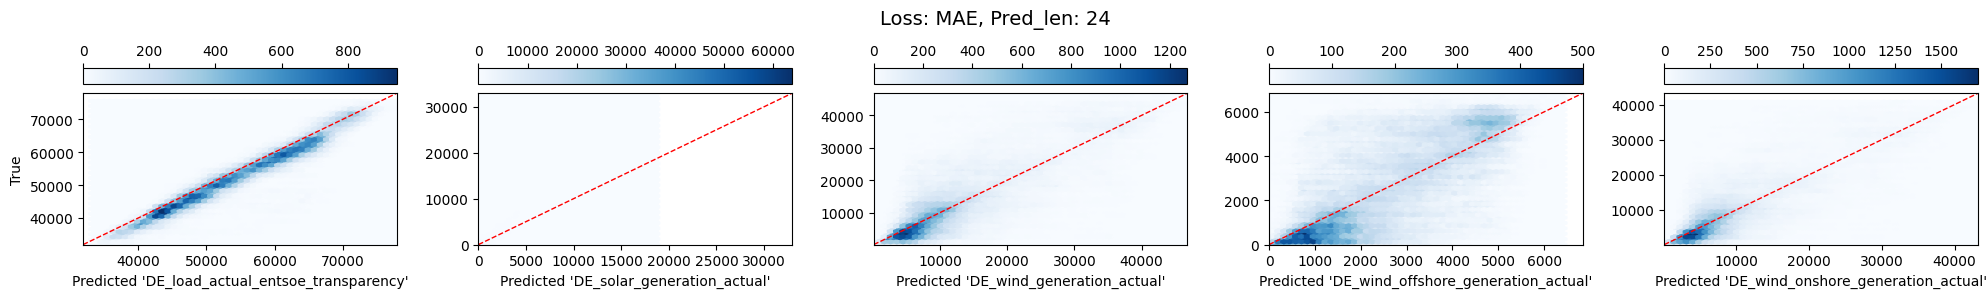

load actual          min value: 31307.00   max value: 78890.42  
solar generation     min value: 0.00       max value: 33563.46  
wind generation      min value: 135.00     max value: 46270.48  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 41356.31  


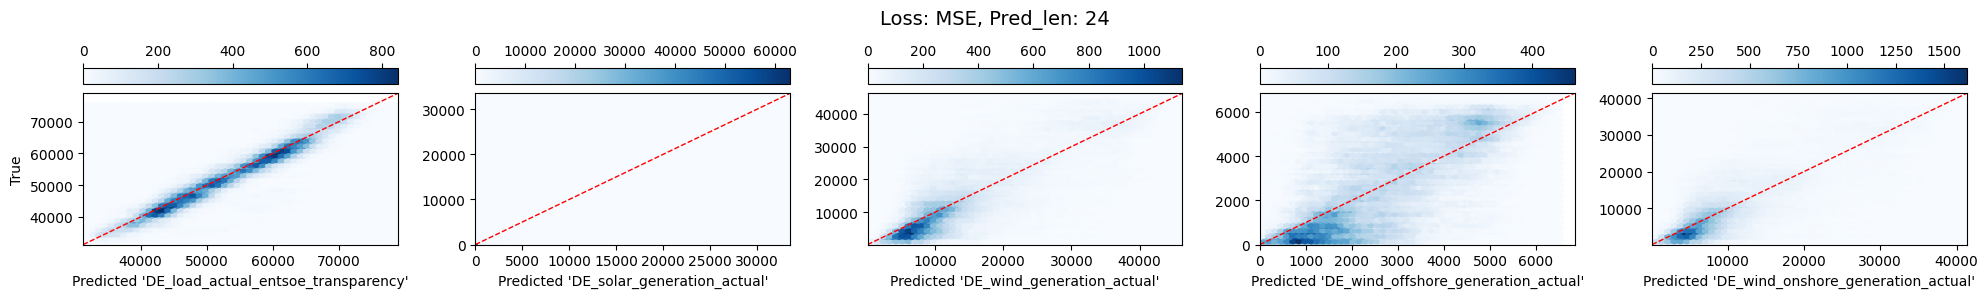

load actual          min value: 31307.00   max value: 77402.55  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


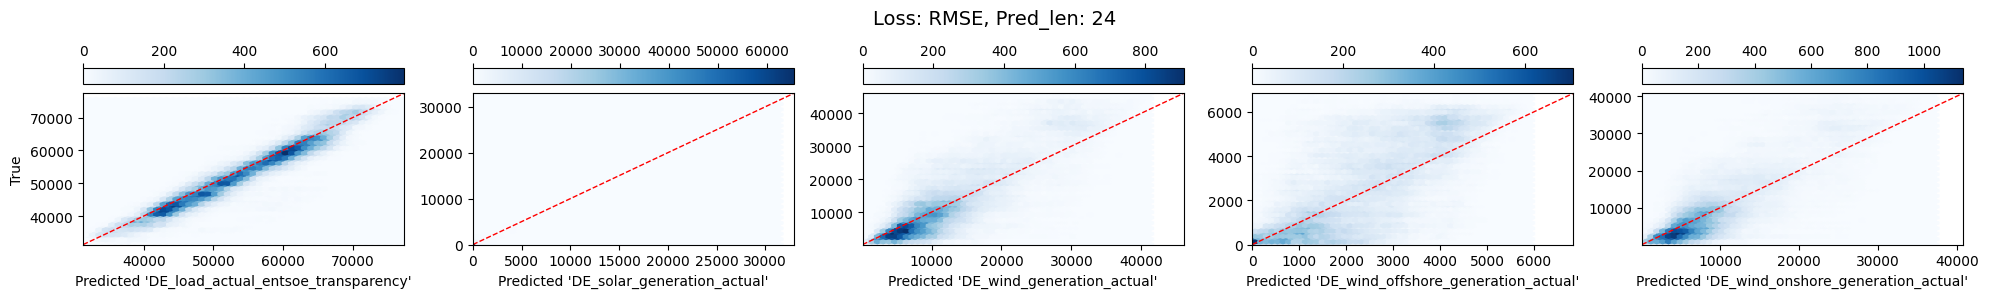

----------------------------------------------------------------------------------------------------------------------------------------------------------------
load actual          min value: 31307.00   max value: 81415.58  
solar generation     min value: 0.00       max value: 34025.97  
wind generation      min value: 136.00     max value: 46302.80  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 41129.13  


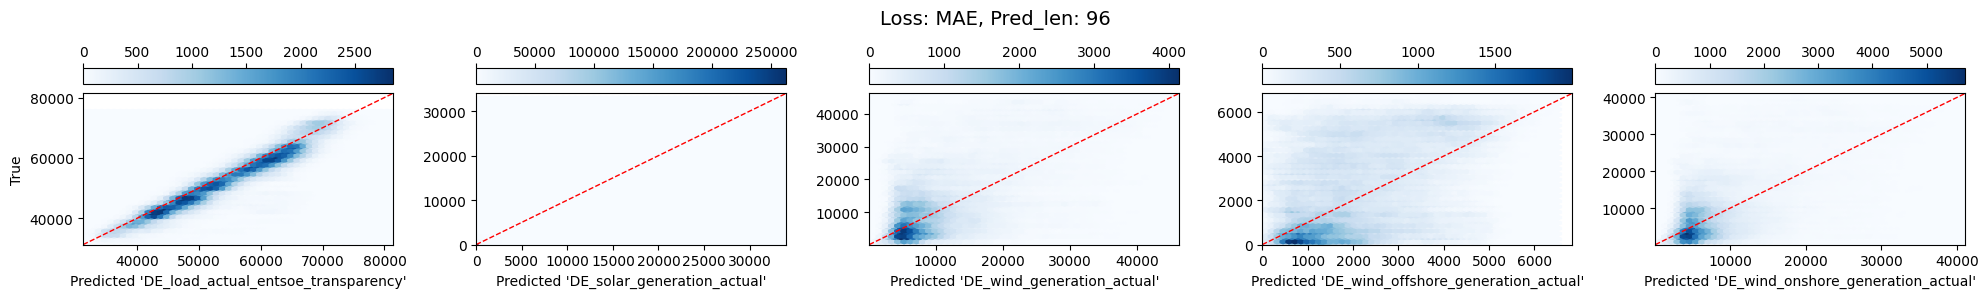

load actual          min value: 31307.00   max value: 79951.81  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


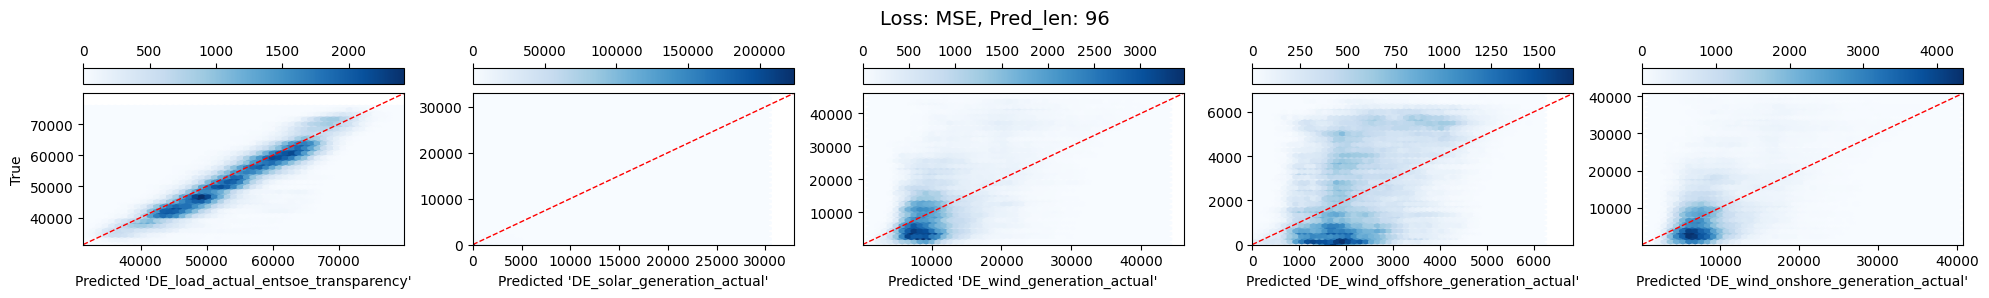

load actual          min value: 31307.00   max value: 79937.38  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 48253.87  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 43765.38  


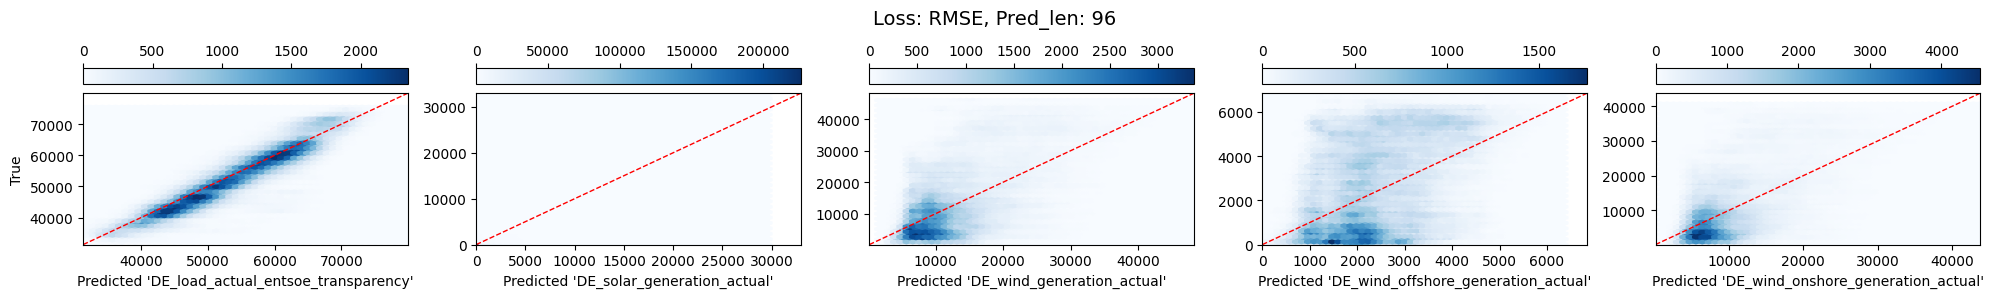

----------------------------------------------------------------------------------------------------------------------------------------------------------------
load actual          min value: 31307.00   max value: 79800.41  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 47309.53  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 42803.87  


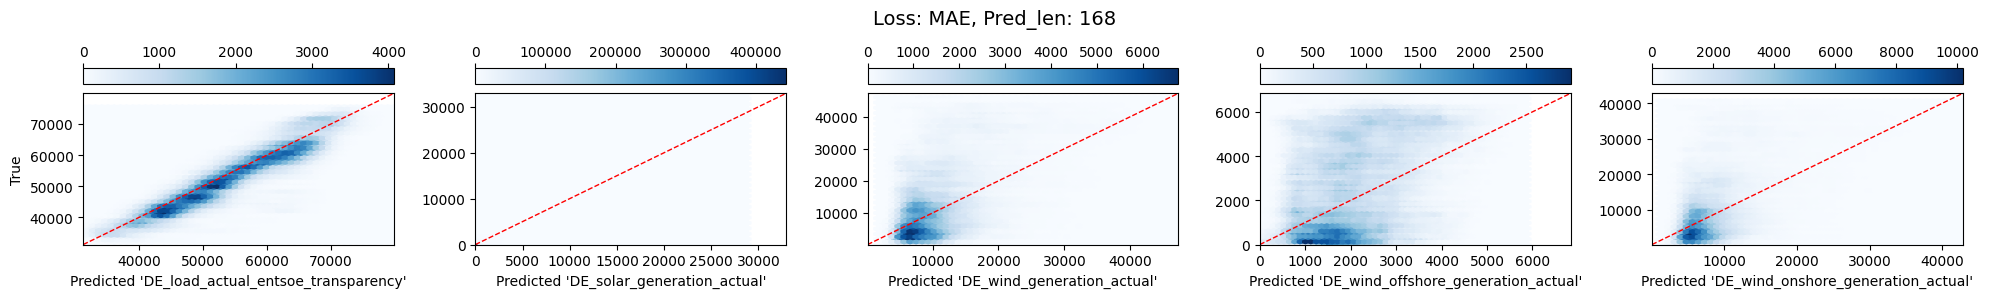

load actual          min value: 31307.00   max value: 77668.05  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


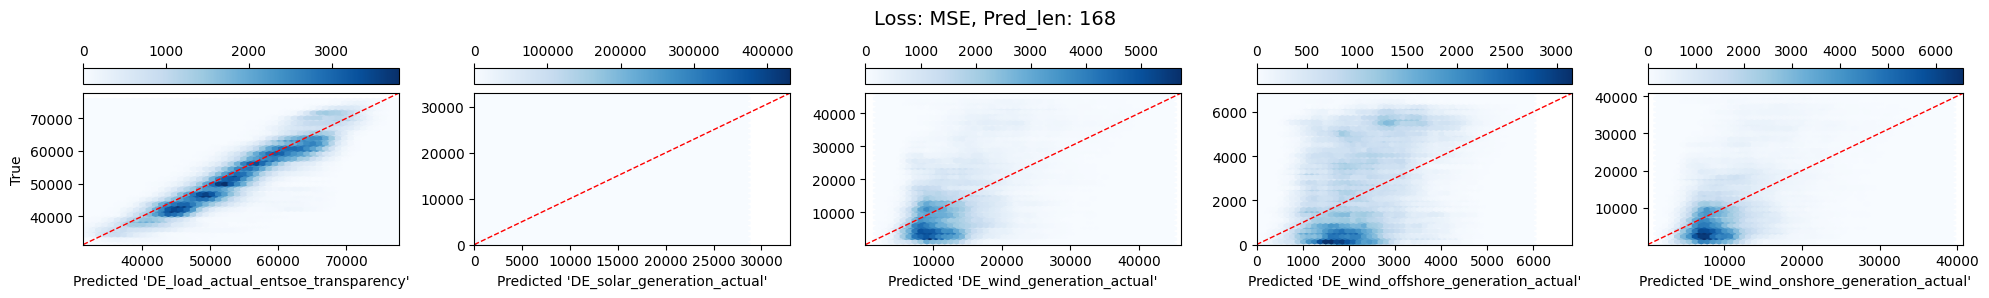

load actual          min value: 31307.00   max value: 78774.30  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


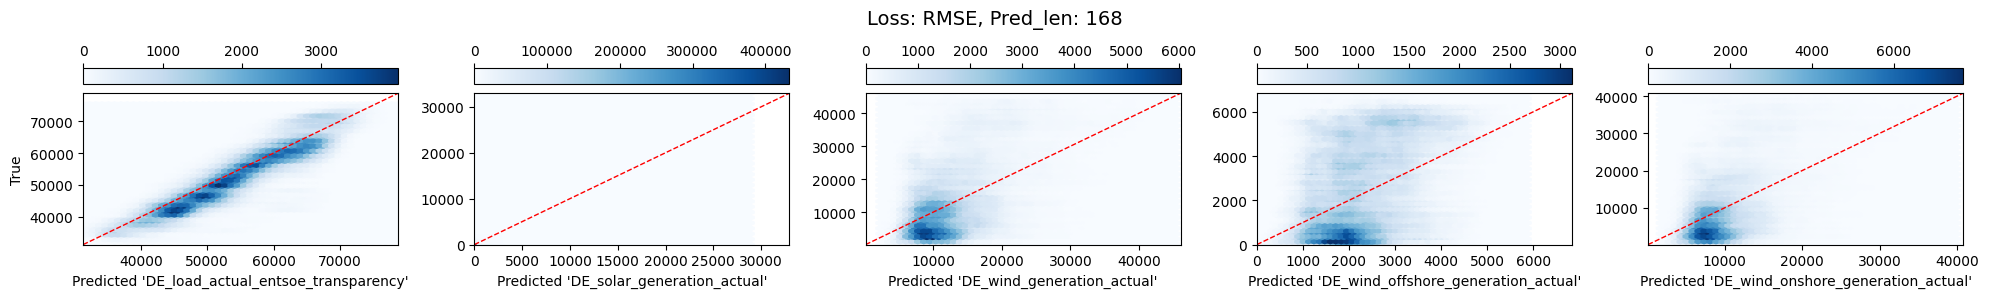

----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [10]:
# Extract columns
cols = pd.read_csv("datasets/DE_data.csv").columns[1:]

#color_maps = ["Blues", "Oranges", "Greens"]
color_maps = ["Blues"]*3 # So easier to compare

# Plots
for pred_len in [24, 96, 168]:
    for i, loss in enumerate(["MAE", "MSE", "RMSE"]):
        plot_error_results("Informer", loss, seq_len=96, pred_len=pred_len, itr=2, columns=cols, color=color_maps[i])
    print("-"*160)


## 4. Plot PatchTST errors

load actual          min value: 31587.75   max value: 75551.00  
solar generation     min value: 0.00       max value: 33588.36  
wind generation      min value: 135.00     max value: 49250.23  
wind offshore        min value: 0.00       max value: 7114.02   
wind onshore         min value: 119.00     max value: 42780.51  


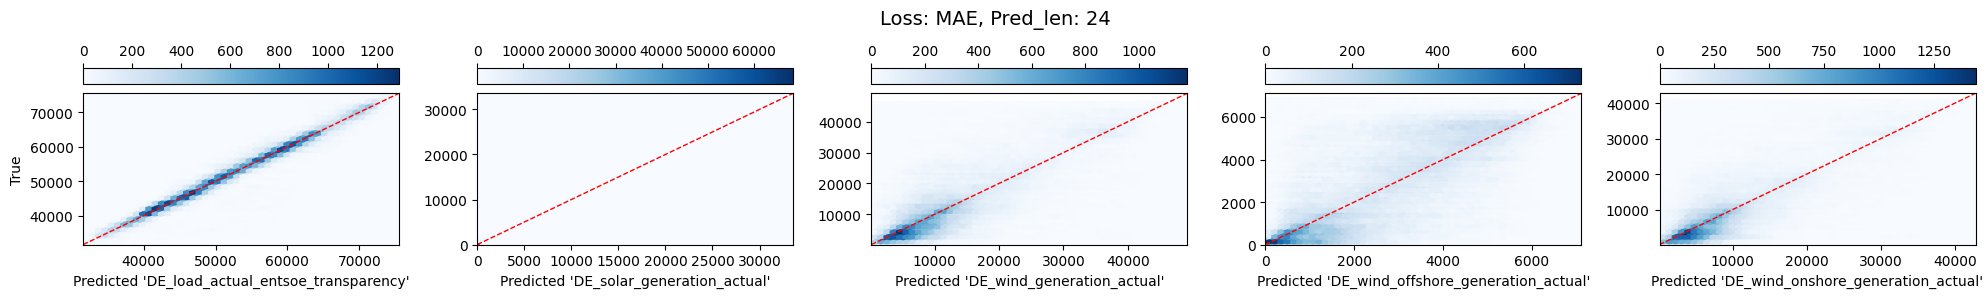

load actual          min value: 31335.98   max value: 76722.77  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 48093.71  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 41868.66  


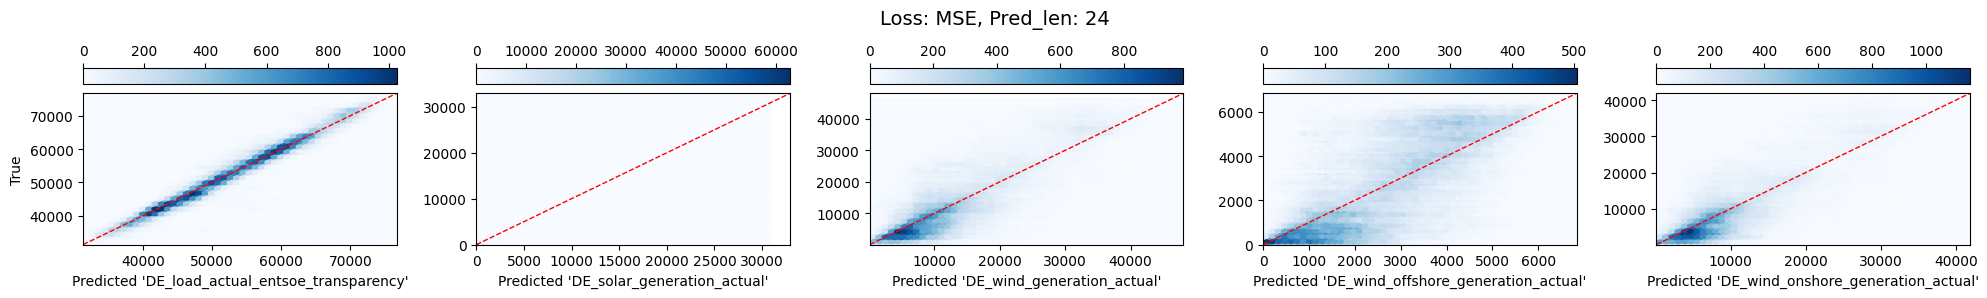

load actual          min value: 31539.59   max value: 75851.88  
solar generation     min value: 0.00       max value: 33227.02  
wind generation      min value: 135.00     max value: 48635.93  
wind offshore        min value: 0.00       max value: 6903.65   
wind onshore         min value: 119.00     max value: 42714.83  


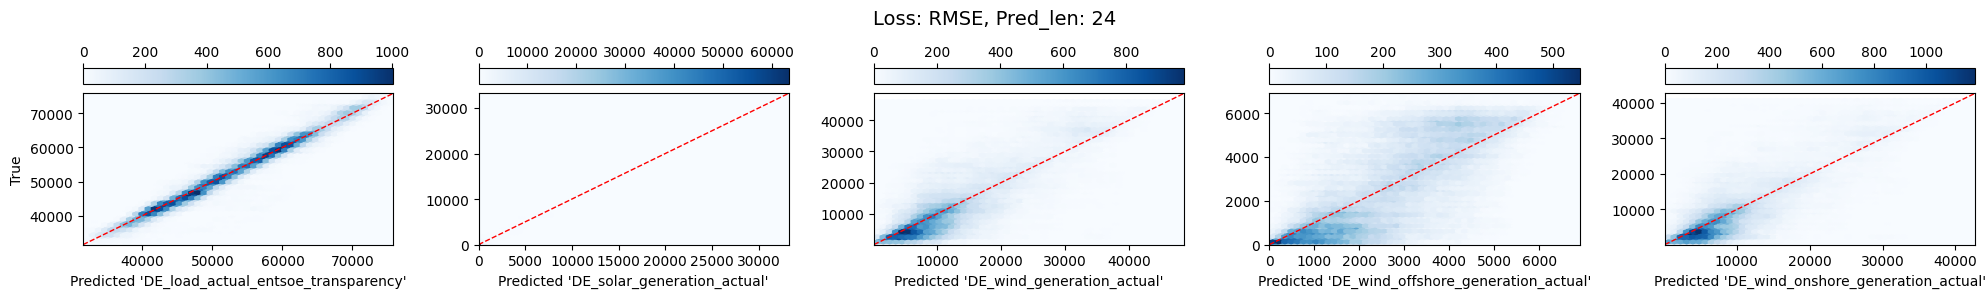

----------------------------------------------------------------------------------------------------------------------------------------------------------------
load actual          min value: 31307.00   max value: 75551.00  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 47922.72  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 41885.04  


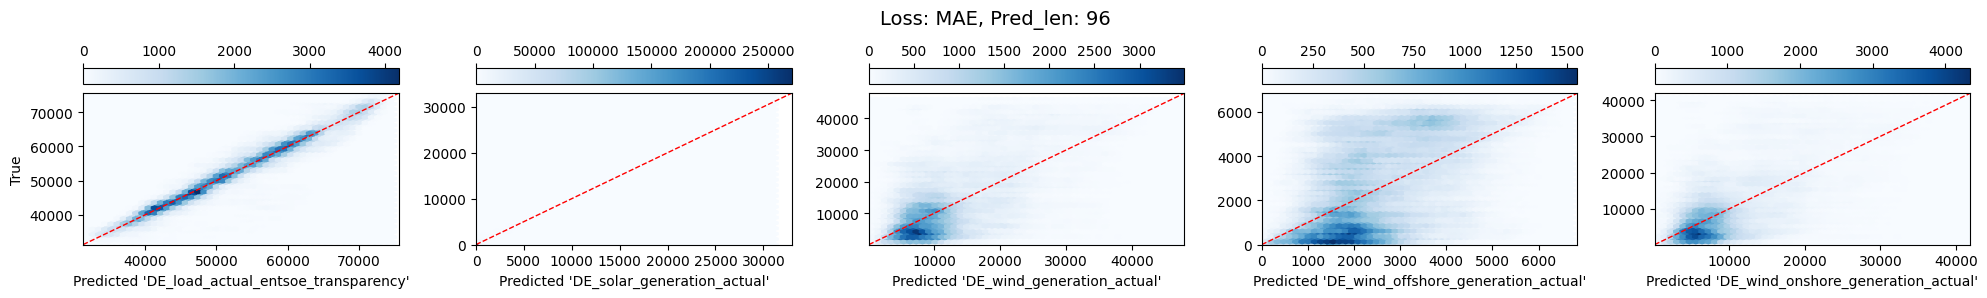

load actual          min value: 31307.00   max value: 75855.28  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


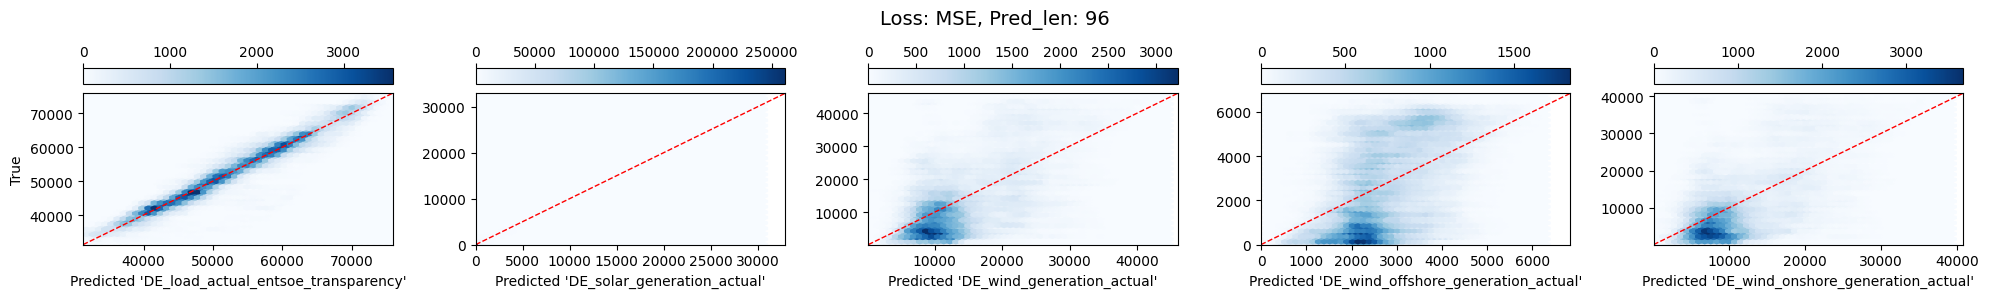

load actual          min value: 31307.00   max value: 75692.48  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


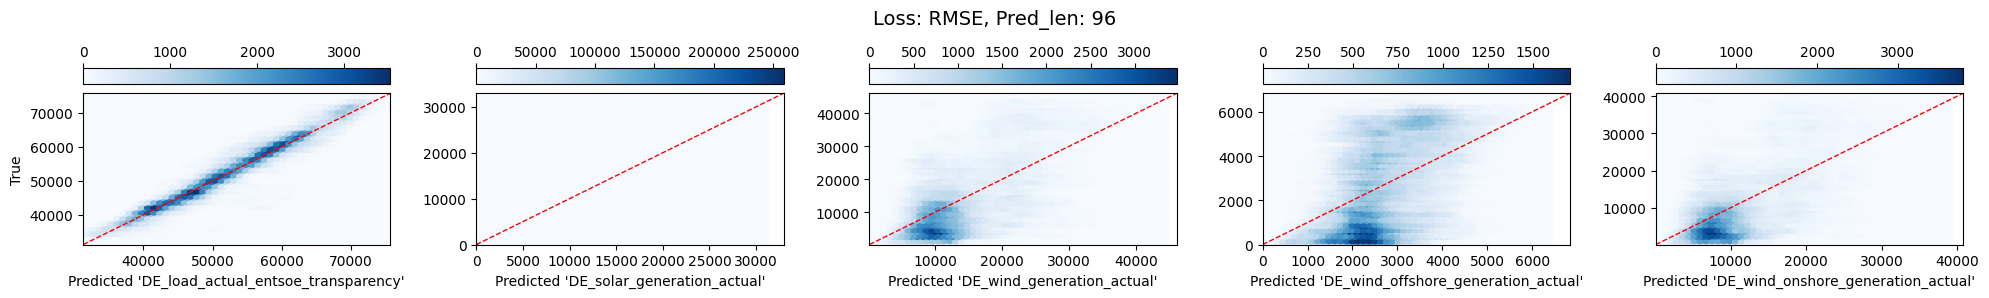

----------------------------------------------------------------------------------------------------------------------------------------------------------------
load actual          min value: 31923.00   max value: 76676.21  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 48092.82  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 42611.30  


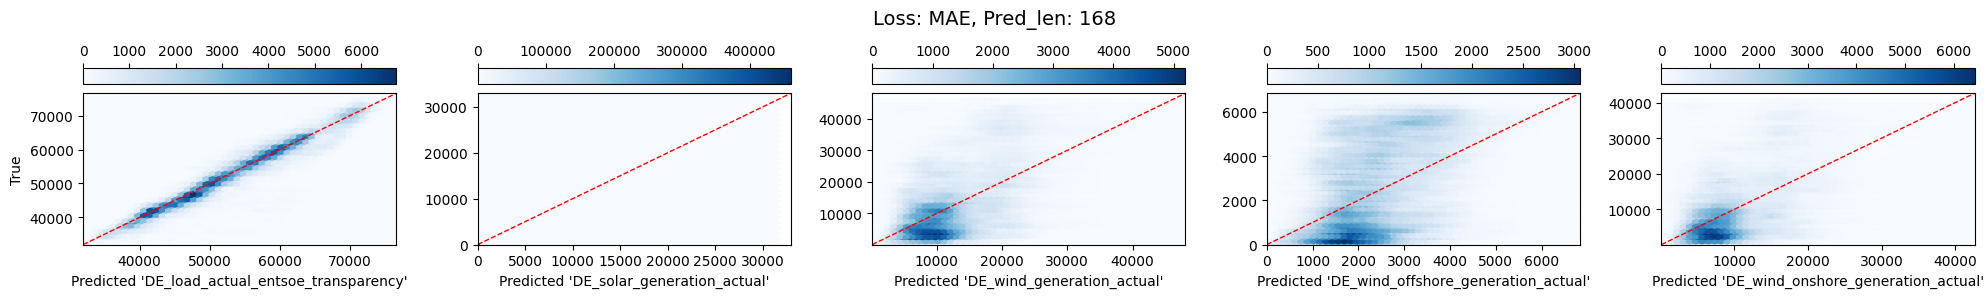

load actual          min value: 31307.00   max value: 75551.00  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


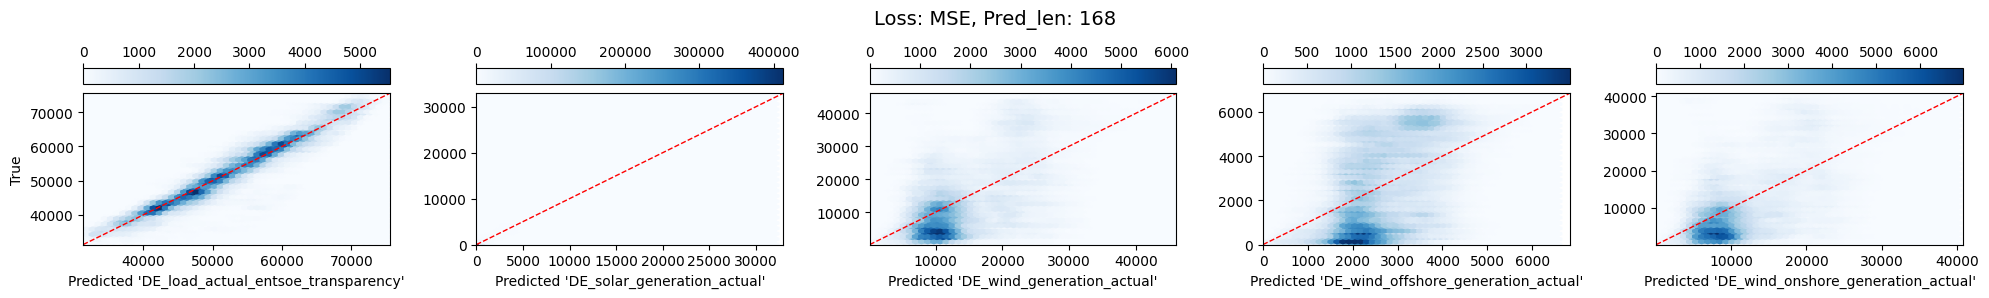

load actual          min value: 31307.00   max value: 75749.61  
solar generation     min value: 0.00       max value: 37344.29  
wind generation      min value: 135.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


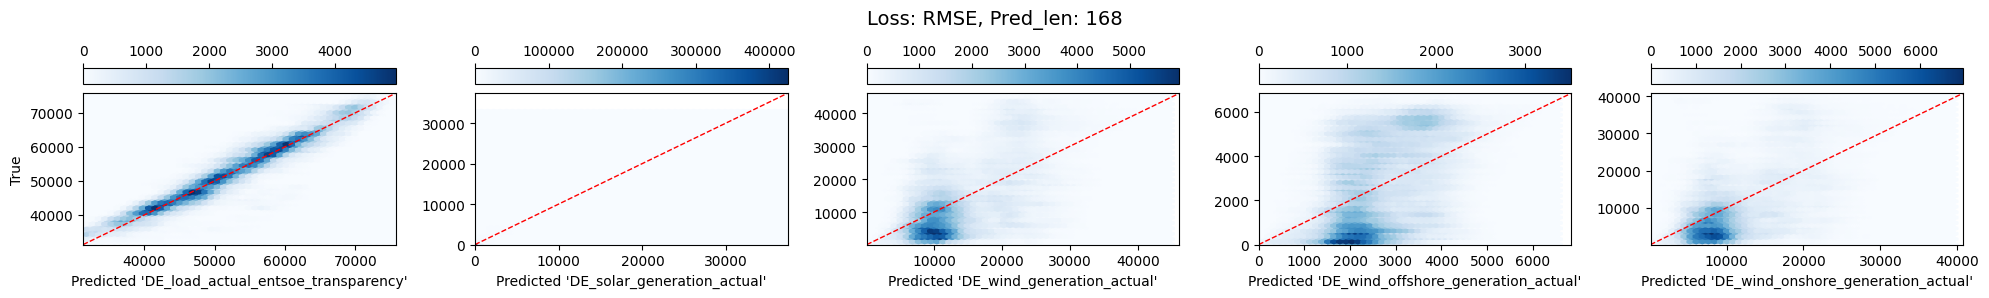

----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [11]:
# Extract columns
cols = pd.read_csv("datasets/DE_data.csv").columns[1:]

#color_maps = ["Blues", "Oranges", "Greens"]
color_maps = ["Blues"]*3 # So easier to compare

# Plots
for pred_len in [24, 96, 168]:
    for i, loss in enumerate(["MAE", "MSE", "RMSE"]):
        plot_error_results("PatchTST", loss, seq_len=512, pred_len=pred_len, itr=2, columns=cols, color=color_maps[i])
    print("-"*160)

# MinMax Scaler (0, 5)

Please note, we dynamically overwrire "results_loss_scaled" and "results_loss_unscaled" because each of them has a weight of 1 GB. All important info is above on the plots, so we basically do not need them anymore. If you want to save them, put them in another directory!

## 1. Informer

In [3]:
# Paths to files and data
data_path = os.getcwd() + "/datasets/"

script_path = "./PatchTST-main/PatchTST_supervised/run_longExp.py"

# Arguments that will be used also for file names
model = "Informer"
dataset = 'DE_data.csv'
losses = ["MSE", "RMSE", "MAE"]
country = dataset[:2]

log_dir = f"logs/loss_choice/min_max_0_5_relu"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

log_file_path = f"{log_dir}/{model}_{country}.log"

In [4]:
# Dynamic variables
pred_lens = ["24", "96", "168"]
seq_len = "96"
lr = "0.0001"
itr = 2  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Lists to store the results
informer_results_scaled, informer_results_unscaled = [], []

# Log file
with open(log_file_path, "w") as log_file:
    for loss in losses:
        statement_1 = f"\n=== Starting experiments for loss function: {loss} ===\n"
        log_file.write(statement_1)
        print(statement_1)  # Print to .ipynb output cell

        for pred_len in pred_lens:
            statement_2 = f"\n=== Starting experiments for pred_len: {pred_len} ===\n"
            log_file.write(statement_2)
            print(statement_2) 
            model_id = f"{country}_{seq_len}_{pred_len}_loss_choice_for_{country}"

            # Arguments for the command
            command = f"""
            python {script_path} \
              --random_seed 2021 \
              --is_training 1 \
              --root_path "{data_path}" \
              --data_path "{dataset}" \
              --model_id {model_id} \
              --model "{model}" \
              --data "custom" \
              --features M \
              --seq_len {seq_len} \
              --label_len 5 \
              --pred_len {pred_len} \
              --e_layers 2 \
              --d_layers 1 \
              --factor 5 \
              --enc_in 5 \
              --dec_in 5 \
              --c_out 5 \
              --des 'Exp' \
              --train_epochs 10 \
              --patience 3 \
              --overlapping_windows \
              --inverse \
              --loss_fnc "{loss}" \
              --activation relu \
              --itr {itr} --batch_size 32 --learning_rate "{lr}"
            """

            # Run the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            # Capture the output in real-time
            output = []
            for line in process.stdout:
                output.append(line)
                print(line, end='')  # Print in the .ipynb cell
                log_file.write(line)  # Write to the log file

            # Wait for the process to complete
            process.wait()
            
            # Delete the checkpoints folder and all its contents
            shutil.rmtree('./checkpoints' )

            # Extract metrics for each iteration
            iteration_metrics = extract_metrics_from_output(output, itr)
            iteration_metrics_unscaled = extract_metrics_from_output(output, itr, if_scaled=False)

            # Log the extracted metrics and save them
            for iteration, (scaled_metrics, unscaled_metrics) in enumerate(zip(iteration_metrics, iteration_metrics_unscaled), start=1):
                log_file.write(f"\nExtracted Metrics for {country}, pred_len={pred_len}, iteration={iteration}:\n")
                log_file.write(f"Scaled Metrics - MSE: {scaled_metrics[0]}, RMSE: {scaled_metrics[1]}, MAE: {scaled_metrics[2]}, RSE: {scaled_metrics[3]}\n")
                log_file.write(f"Unscaled Metrics - MSE: {unscaled_metrics[0]}, RMSE: {unscaled_metrics[1]}, MAE: {unscaled_metrics[2]}, RSE: {unscaled_metrics[3]}\n")

                # Append the results to the informer_results lists
                metrics_data = [(informer_results_scaled, scaled_metrics), (informer_results_unscaled, unscaled_metrics)]

                for result_list, metrics in metrics_data:
                    result_list.append({
                        'Loss_function': loss,
                        'Pred_len': pred_len,
                        'Iteration': iteration,
                        'MSE': metrics[0],
                        'RMSE': metrics[1],
                        'MAE': metrics[2],
                        'RSE': metrics[3]
                    })


=== Starting experiments for loss function: MSE ===


=== Starting experiments for pred_len: 24 ===

Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='DE_96_24_loss_choice_for_DE', model='Informer', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='DE_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', overlapping_windows=True, seq_len=96, label_len=5, pred_len=24, inverse=True, loss_fnc='MSE', fc_dropout=0.05, head_dropout=0.0, patch_len=16, stride=8, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=5, distil=True, dropout=0.05, embed='timeF', activation='relu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', lradj='type3', pct_start=0.3, us

In [5]:
path_dir = './dataset_results'
csv_name_scaled = 'informer_loss_functions_results_scaled_minmax.csv'
csv_name_unscaled = 'informer_loss_functions_results_unscaled_minmax.csv'

# Convert the results into a DataFrame and save as CSV
informer_df_scaled = convert_results_into_df(informer_results_scaled, path_dir, csv_name_scaled)
informer_df_unscaled = convert_results_into_df(informer_results_unscaled, path_dir, csv_name_unscaled)
informer_df_scaled.round(4)

MSE    RMSE     MAE     RSE
Loss_function Iteration Pred_len                                
MSE           1         24        0.5900  0.7681  0.5134  0.5425
              2         24        0.5565  0.7460  0.5017  0.5269
              1         96        0.9737  0.9868  0.7140  0.6989
              2         96        1.0281  1.0139  0.7083  0.7181
              1         168       1.0188  1.0093  0.7099  0.7152
              2         168       1.0490  1.0242  0.7395  0.7257
RMSE          1         24        0.5771  0.7597  0.5050  0.5365
              2         24        0.5795  0.7613  0.5110  0.5377
              1         96        0.9812  0.9905  0.7067  0.7015
              2         96        1.0184  1.0091  0.7146  0.7147
              1         168       1.0020  1.0010  0.7067  0.7093
              2         168       1.1629  1.0784  0.7698  0.7641
MAE           1         24        0.6073  0.7793  0.4910  0.5504
              2         24        0.5877  0.7666  0.4944  0.5415
              1         96        0.9911  0.9955  0.6899  0.7051
              2         96        1.0454  1.0224  0.7026  0.7241
              1         168       1.0631  1.0311  0.7205  0.7306
              2         168       1.0521  1.0257  0.7103  0.7268

In [6]:
informer_df_unscaled.round(4)

MSE       RMSE        MAE     RSE
Loss_function Iteration Pred_len                                          
MSE           1         24        20480482.0  4525.5366  2909.4851  0.2250
              2         24        18213778.0  4267.7603  2791.6816  0.2122
              1         96        35709004.0  5975.7012  4075.1108  0.2976
              2         96        36943168.0  6078.0894  3976.2830  0.3027
              1         168       36735616.0  6060.9912  3992.3479  0.3020
              2         168       38725652.0  6222.9937  4226.7588  0.3101
RMSE          1         24        19703646.0  4438.8789  2844.3523  0.2207
              2         24        19322682.0  4395.7573  2863.1350  0.2186
              1         96        35458704.0  5954.7212  4002.4402  0.2965
              2         96        36999436.0  6082.7163  4040.1528  0.3029
              1         168       36233816.0  6019.4531  3968.3572  0.2999
              2         168       45239896.0  6726.0610  4444.7422  0.3351
MAE           1         24        20904604.0  4572.1553  2763.4695  0.2273
              2         24        19740060.0  4442.9785  2748.1685  0.2209
              1         96        35747956.0  5978.9595  3889.9070  0.2978
              2         96        38837292.0  6231.9575  4011.7781  0.3104
              1         168       38654340.0  6217.2612  4107.8438  0.3098
              2         168       38850424.0  6233.0107  4030.0308  0.3106

In [7]:
# Uncomment the following lines if you want to read saved results
#path_dir = './dataset_results'
#csv_name_scaled = 'informer_loss_functions_results_scaled_minmax.csv'
#csv_name_unscaled = 'informer_loss_functions_results_unscaled_minmax.csv'

# Average the iterations
informer_scaled = pd.read_csv(os.path.join(path_dir, csv_name_scaled))
informer_unscaled = pd.read_csv(os.path.join(path_dir, csv_name_unscaled))

inf_res_scaled = informer_scaled.groupby(['Pred_len', 'Loss_function']).mean().drop('Iteration', axis=1)
inf_res_unscaled = informer_unscaled.groupby(['Pred_len', 'Loss_function']).mean().sort_index().drop('Iteration', axis=1)
inf_res_scaled.round(4)

MSE    RMSE     MAE     RSE
Pred_len Loss_function                                
24       MAE            0.5975  0.7730  0.4927  0.5460
         MSE            0.5732  0.7570  0.5075  0.5347
         RMSE           0.5783  0.7605  0.5080  0.5371
96       MAE            1.0182  1.0090  0.6962  0.7146
         MSE            1.0009  1.0003  0.7112  0.7085
         RMSE           0.9998  0.9998  0.7107  0.7081
168      MAE            1.0576  1.0284  0.7154  0.7287
         MSE            1.0339  1.0168  0.7247  0.7204
         RMSE           1.0825  1.0397  0.7382  0.7367

In [8]:
inf_res_unscaled.round(4)

MSE       RMSE        MAE     RSE
Pred_len Loss_function                                          
24       MAE            20322332.0  4507.5669  2755.8190  0.2241
         MSE            19347130.0  4396.6484  2850.5834  0.2186
         RMSE           19513164.0  4417.3181  2853.7437  0.2196
96       MAE            37292624.0  6105.4585  3950.8425  0.3041
         MSE            36326086.0  6026.8953  4025.6969  0.3001
         RMSE           36229070.0  6018.7188  4021.2965  0.2997
168      MAE            38752382.0  6225.1360  4068.9373  0.3102
         MSE            37730634.0  6141.9924  4109.5533  0.3060
         RMSE           40736856.0  6372.7571  4206.5497  0.3175

In [ ]:
# Pred_len index was stored as a string, convert it to int
#inf_res_scaled.index = inf_res_scaled.index.set_levels([inf_res_scaled.index.levels[0].astype(int), inf_res_scaled.index.levels[1]])
#inf_res_scaled.sort_index(inplace=True)

## 2. PatchTST

In [9]:
# Dynamic variables
pred_lens = ["24", "96", "168"]
seq_len = "512"
lr = "0.0001"
model = "PatchTST"
itr = 2  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# New log file path
log_file_path = f"{log_dir}/{model}_{country}.log"

patchtst_results_scaled, patchtst_results_unscaled = [], []

with open(log_file_path, "w") as log_file:
    for loss in losses:
        statement_1 = f"\n=== Starting experiments for loss function: {loss} ===\n"
        log_file.write(statement_1)
        print(statement_1)  # Print to notebook

        for pred_len in pred_lens:
            statement_2 = f"\n=== Starting experiments for pred_len: {pred_len} ===\n"
            log_file.write(statement_2)
            print(statement_2) 
            model_id = f"{country}_{seq_len}_{pred_len}_loss_choice_for_{country}"

            # Command arguments
            command = f"""
            python {script_path} \
              --random_seed 2021 \
              --is_training 1 \
              --root_path "{data_path}" \
              --data_path "{dataset}" \
              --model_id {model_id} \
              --model "{model}" \
              --data "custom" \
              --features M \
              --seq_len {seq_len} \
              --label_len 5 \
              --pred_len {pred_len} \
              --e_layers 2 \
              --d_layers 1 \
              --factor 5 \
              --enc_in 5 \
              --dec_in 5 \
              --c_out 5 \
              --des 'Exp' \
              --train_epochs 10 \
              --patience 3 \
              --overlapping_windows \
              --inverse \
              --loss_fnc "{loss}" \
              --activation relu \
              --itr {itr} --batch_size 32 --learning_rate "{lr}"
            """

            # Run the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            # Capture the output in real-time
            output = []
            for line in process.stdout:
                output.append(line)
                print(line, end='')  # Print in the .ipynb cell
                log_file.write(line)  # Write to the log file

            # Wait for the process to complete
            process.wait()

            # Delete the checkpoints folder and all its contents
            shutil.rmtree('./checkpoints' )

            # Extract metrics for each iteration
            iteration_metrics_scaled = extract_metrics_from_output(output, itr)
            iteration_metrics_unscaled = extract_metrics_from_output(output, itr, if_scaled=False)

            # Log the extracted metrics and save them
            for iteration, (scaled_metrics, unscaled_metrics) in enumerate(zip(iteration_metrics_scaled, iteration_metrics_unscaled), start=1):
                log_file.write(f"\nExtracted Metrics for {country}, pred_len={pred_len}, iteration={iteration}:\n")
                log_file.write(f"Scaled Metrics - MSE: {scaled_metrics[0]}, RMSE: {scaled_metrics[1]}, MAE: {scaled_metrics[2]}, RSE: {scaled_metrics[3]}\n")
                log_file.write(f"Unscaled Metrics - MSE: {unscaled_metrics[0]}, RMSE: {unscaled_metrics[1]}, MAE: {unscaled_metrics[2]}, RSE: {unscaled_metrics[3]}\n")

                # Append the results to the informer_results lists
                metrics_data = [(patchtst_results_scaled, scaled_metrics), (patchtst_results_unscaled, unscaled_metrics)]

                for result_list, metrics in metrics_data:
                    result_list.append({
                        'Loss_function': loss,
                        'Pred_len': pred_len,
                        'Iteration': iteration,
                        'MSE': metrics[0],
                        'RMSE': metrics[1],
                        'MAE': metrics[2],
                        'RSE': metrics[3]
                    })


=== Starting experiments for loss function: MSE ===


=== Starting experiments for pred_len: 24 ===



Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='DE_512_24_loss_choice_for_DE', model='PatchTST', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='DE_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', overlapping_windows=True, seq_len=512, label_len=5, pred_len=24, inverse=True, loss_fnc='MSE', fc_dropout=0.05, head_dropout=0.0, patch_len=16, stride=8, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=5, distil=True, dropout=0.05, embed='timeF', activation='relu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', lradj='type3', pct_start=0.3, use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', test_flop=False)
Use GPU: 

In [10]:
path_dir = './dataset_results'
csv_name_scaled = 'patchtst_loss_functions_results_scaled_minmax.csv'
csv_name_unscaled = 'patchtst_loss_functions_results_unscaled_minmax.csv'


# Convert the results into a DataFrame and save as CSV
patchtst_df_scaled = convert_results_into_df(patchtst_results_scaled, path_dir, csv_name_scaled)
patchtst_df_unscaled = convert_results_into_df(patchtst_results_unscaled, path_dir, csv_name_unscaled)
patchtst_df_scaled.round(4)

MSE    RMSE     MAE     RSE
Loss_function Iteration Pred_len                                
MSE           1         24        0.5360  0.7321  0.4716  0.5171
              2         24        0.5333  0.7303  0.4712  0.5158
              1         96        0.8908  0.9438  0.6565  0.6685
              2         96        0.9085  0.9531  0.6624  0.6750
              1         168       0.9642  0.9819  0.6851  0.6957
              2         168       0.9401  0.9696  0.6843  0.6870
RMSE          1         24        0.5414  0.7358  0.4735  0.5197
              2         24        0.5330  0.7301  0.4693  0.5156
              1         96        0.8934  0.9452  0.6558  0.6694
              2         96        0.8944  0.9457  0.6557  0.6698
              1         168       0.9804  0.9902  0.6853  0.7016
              2         168       0.9393  0.9691  0.6835  0.6867
MAE           1         24        0.5424  0.7365  0.4505  0.5202
              2         24        0.5394  0.7344  0.4493  0.5187
              1         96        0.8917  0.9443  0.6294  0.6688
              2         96        0.9266  0.9626  0.6355  0.6817
              1         168       0.9621  0.9809  0.6685  0.6950
              2         168       0.9993  0.9997  0.6711  0.7083

In [11]:
patchtst_df_unscaled.round(4)

MSE       RMSE        MAE     RSE
Loss_function Iteration Pred_len                                          
MSE           1         24        17142486.0  4140.3486  2565.9302  0.2059
              2         24        17089198.0  4133.9082  2575.7898  0.2055
              1         96        31524144.0  5614.6367  3636.7886  0.2796
              2         96        33323196.0  5772.6245  3707.9365  0.2875
              1         168       34983416.0  5914.6782  3824.7483  0.2947
              2         168       34048708.0  5835.1270  3839.2070  0.2907
RMSE          1         24        17373884.0  4168.1992  2577.1997  0.2073
              2         24        17012618.0  4124.6357  2558.6548  0.2051
              1         96        31708800.0  5631.0566  3635.2244  0.2804
              2         96        32409162.0  5692.9043  3661.5996  0.2835
              1         168       35351660.0  5945.7261  3821.0962  0.2962
              2         168       33994148.0  5830.4502  3832.3152  0.2905
MAE           1         24        16739734.0  4091.4221  2419.3403  0.2034
              2         24        16871196.0  4107.4561  2425.1201  0.2042
              1         96        31304240.0  5595.0190  3466.7358  0.2786
              2         96        32648818.0  5713.9146  3491.8354  0.2846
              1         168       34872248.0  5905.2729  3729.8071  0.2942
              2         168       35697720.0  5974.7568  3709.1443  0.2977

In [13]:
# Uncomment the following lines if you want to read saved results
path_dir = './dataset_results'
csv_name_scaled = 'patchtst_loss_functions_results_scaled_minmax.csv'
csv_name_unscaled = 'patchtst_loss_functions_results_unscaled_minmax.csv'

# Average the iterations
ptst_scaled = pd.read_csv(os.path.join(path_dir, csv_name_scaled))
ptst_unscaled = pd.read_csv(os.path.join(path_dir, csv_name_unscaled))

ptst_res_scaled = ptst_scaled.groupby(['Pred_len', 'Loss_function']).mean().drop('Iteration', axis=1)
ptst_res_scaled.round(4)

MSE    RMSE     MAE     RSE
Pred_len Loss_function                                
24       MAE            0.5409  0.7354  0.4499  0.5194
         MSE            0.5346  0.7312  0.4714  0.5164
         RMSE           0.5372  0.7329  0.4714  0.5177
96       MAE            0.9091  0.9534  0.6325  0.6753
         MSE            0.8996  0.9485  0.6595  0.6718
         RMSE           0.8939  0.9455  0.6558  0.6696
168      MAE            0.9807  0.9903  0.6698  0.7016
         MSE            0.9521  0.9758  0.6847  0.6914
         RMSE           0.9598  0.9797  0.6844  0.6941

In [14]:
ptst_res_unscaled = ptst_unscaled.groupby(['Pred_len', 'Loss_function']).mean().drop('Iteration', axis=1)
ptst_res_unscaled.round(4)

MSE       RMSE        MAE     RSE
Pred_len Loss_function                                          
24       MAE            16805465.0  4099.4391  2422.2302  0.2038
         MSE            17115842.0  4137.1284  2570.8600  0.2057
         RMSE           17193251.0  4146.4175  2567.9272  0.2062
96       MAE            31976529.0  5654.4668  3479.2856  0.2816
         MSE            32423670.0  5693.6306  3672.3625  0.2835
         RMSE           32058981.0  5661.9805  3648.4120  0.2820
168      MAE            35284984.0  5940.0149  3719.4757  0.2960
         MSE            34516062.0  5874.9026  3831.9777  0.2927
         RMSE           34672904.0  5888.0881  3826.7057  0.2934

## 3. Informer errors

We plot unscaled data for each column.

The more the line is narrow and corresponds to the 45 degree line and symmetric around it - the better. Please note that we observe such patterns because of original shapes of distributions within our data. 


Dark spots mean more observations.


load actual          min value: 31923.00   max value: 75551.00  
solar generation     min value: 0.00       max value: 32951.61  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


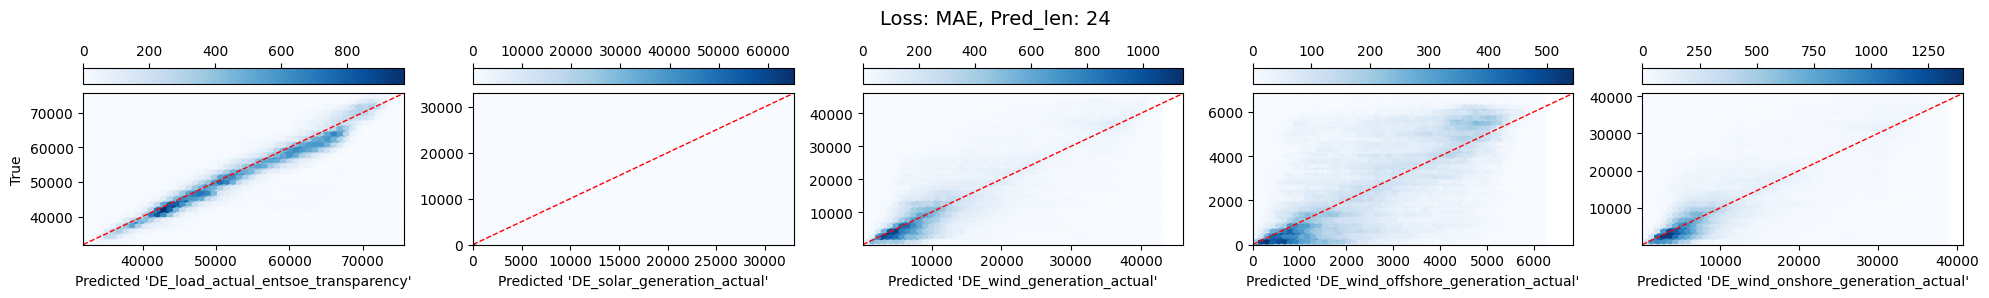

load actual          min value: 31468.38   max value: 75552.53  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


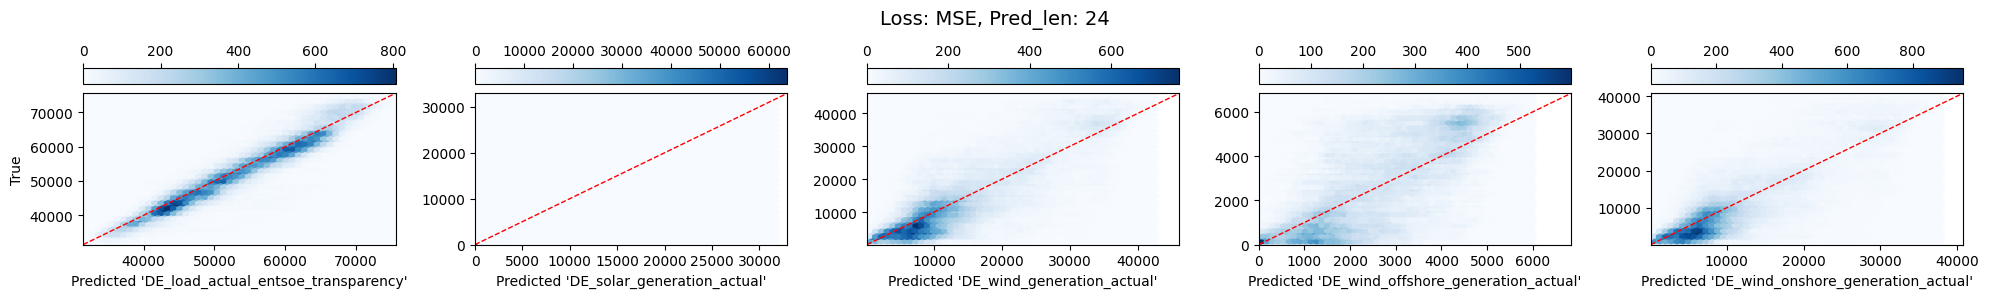

load actual          min value: 31728.07   max value: 75551.00  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


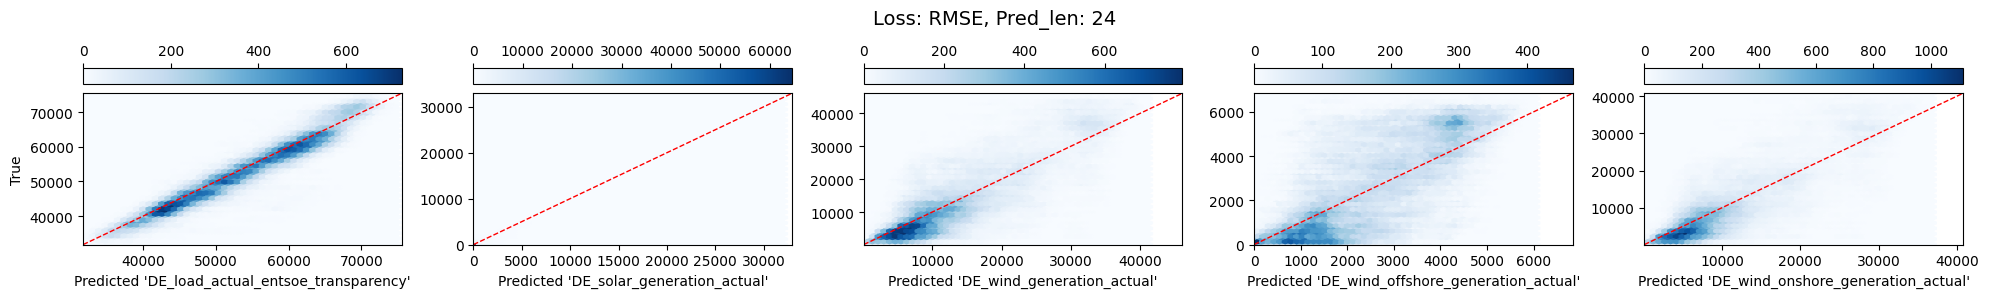

----------------------------------------------------------------------------------------------------------------------------------------------------------------
load actual          min value: 31923.00   max value: 75615.57  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


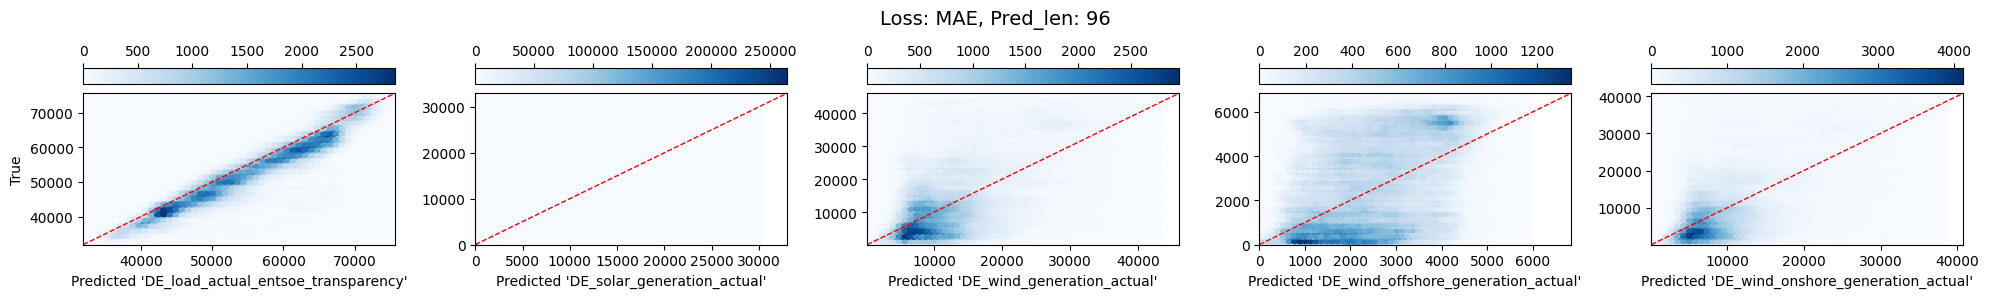

load actual          min value: 31307.00   max value: 76149.77  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


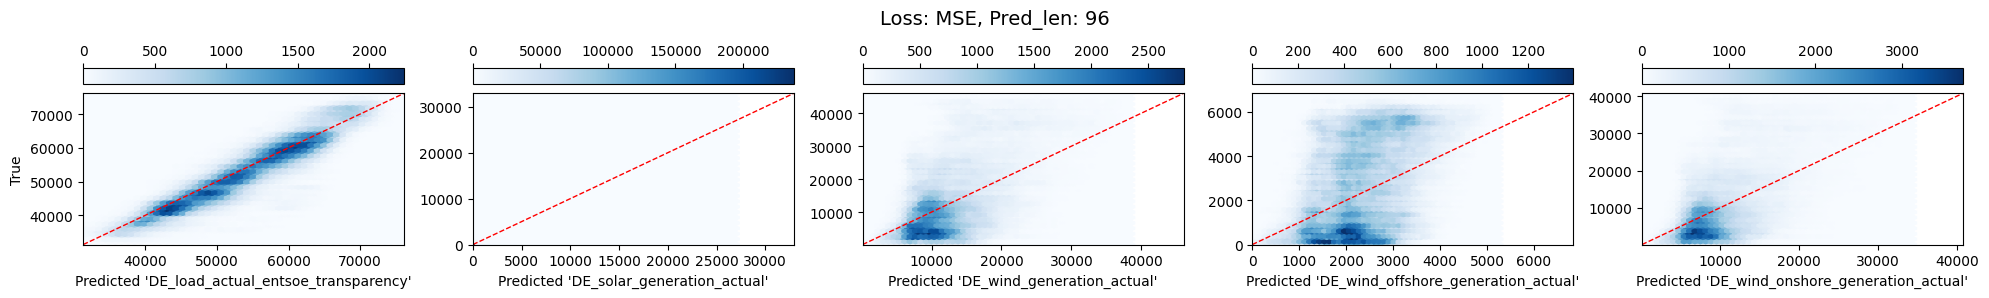

load actual          min value: 31307.00   max value: 77426.69  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


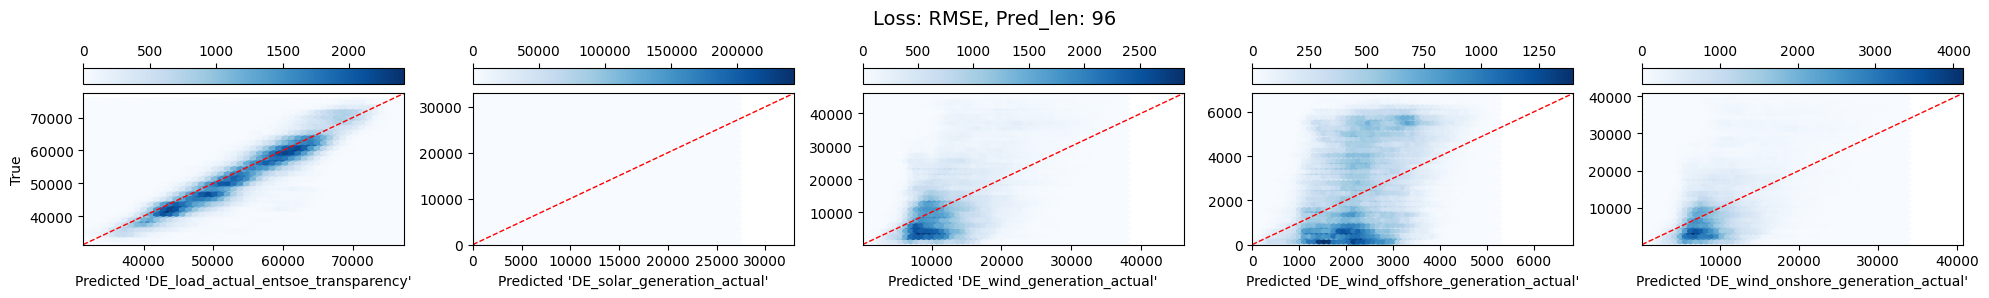

----------------------------------------------------------------------------------------------------------------------------------------------------------------
load actual          min value: 31923.00   max value: 76016.25  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


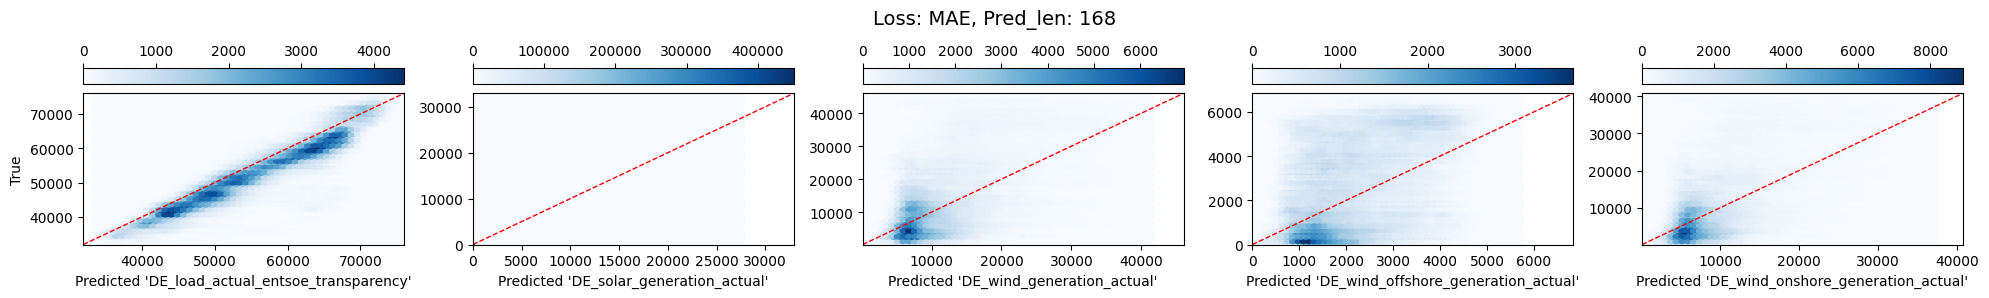

load actual          min value: 31307.00   max value: 80383.12  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


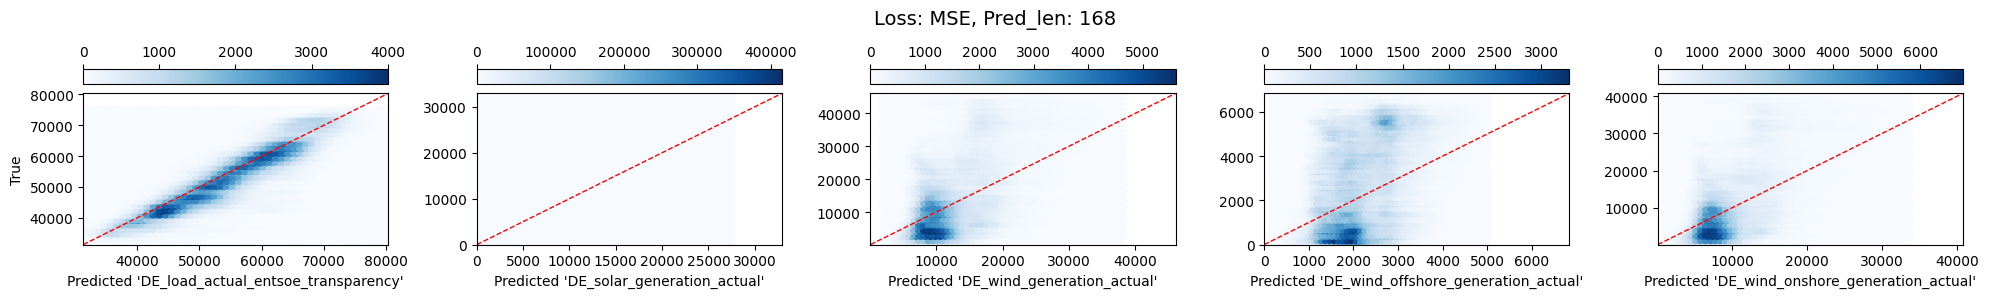

load actual          min value: 31923.00   max value: 76463.03  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


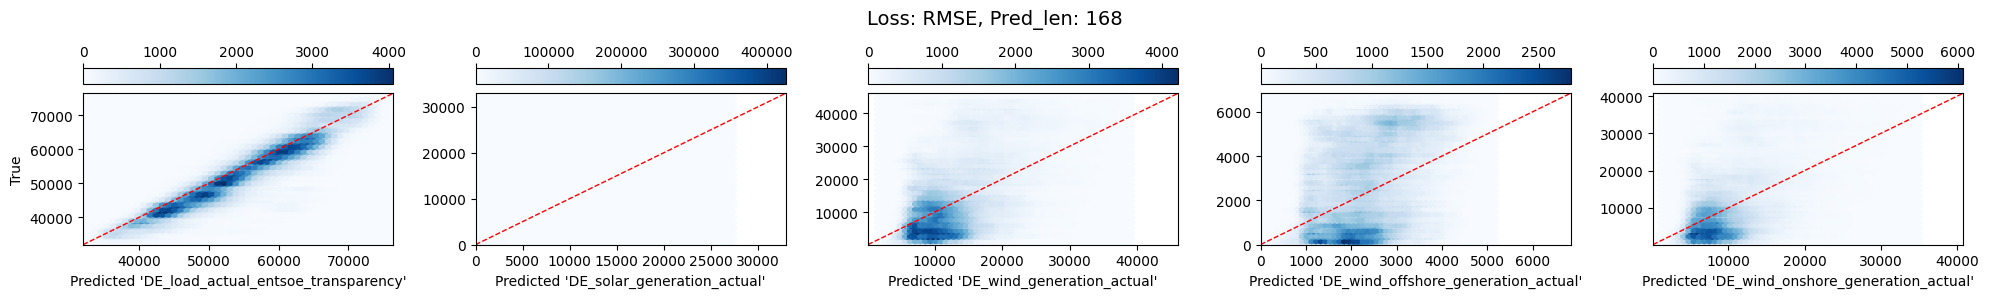

----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [14]:
# Extract columns
cols = pd.read_csv("datasets/DE_data.csv").columns[1:]

#color_maps = ["Blues", "Oranges", "Greens"]
color_maps = ["Blues"]*3 # So easier to compare

# Plots
for pred_len in [24, 96, 168]:
    for i, loss in enumerate(["MAE", "MSE", "RMSE"]):
        plot_error_results("Informer", loss, seq_len=96, pred_len=pred_len, itr=2, columns=cols, color=color_maps[i])
    print("-"*160)


## 4. PatchTST errors

load actual          min value: 31923.00   max value: 76111.86  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 48961.59  
wind offshore        min value: 0.00       max value: 7384.48   
wind onshore         min value: 119.00     max value: 42643.50  


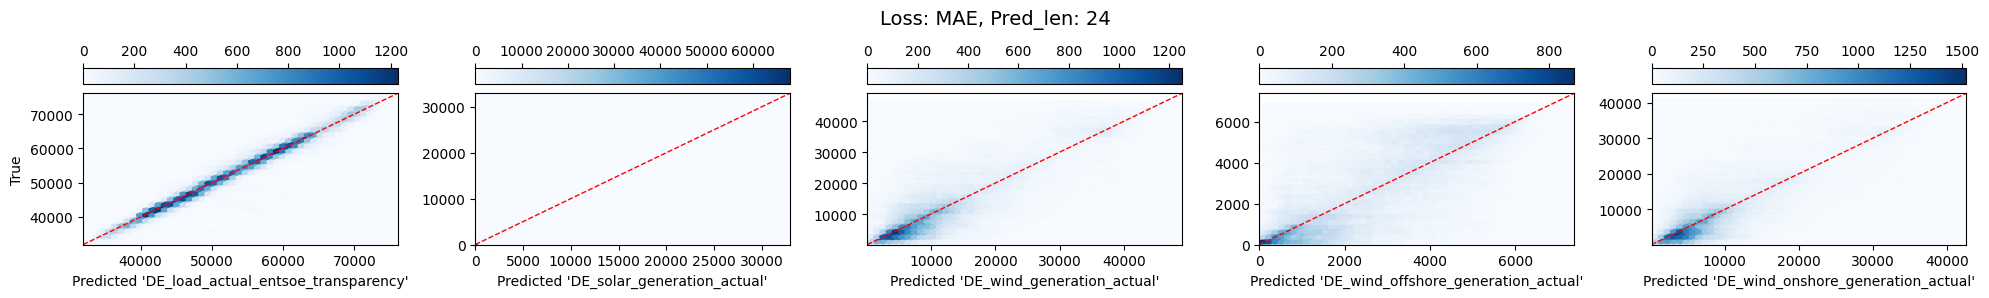

load actual          min value: 31307.00   max value: 76898.62  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 47849.09  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 41619.64  


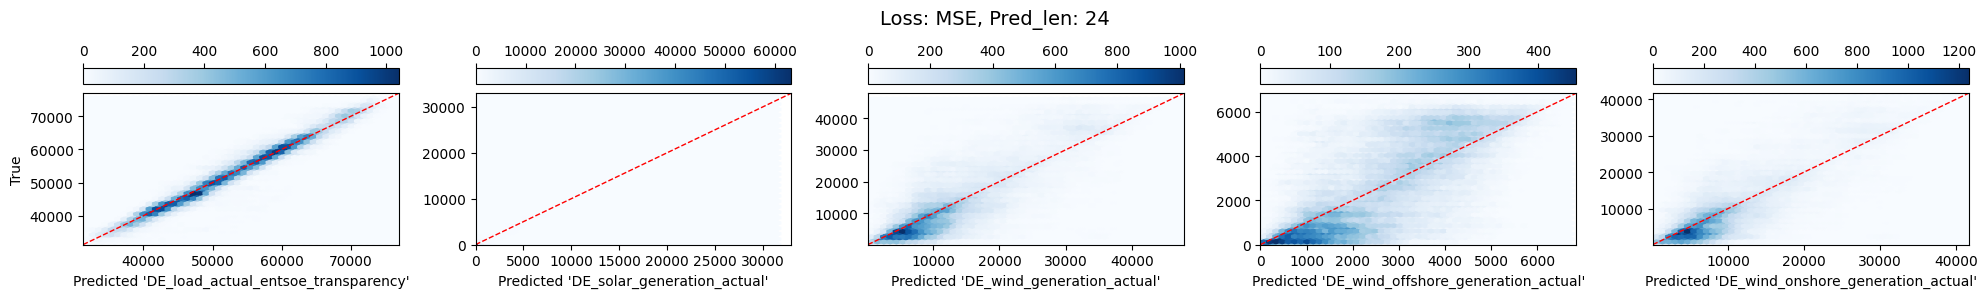

load actual          min value: 31307.00   max value: 76366.70  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 48542.34  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 42163.70  


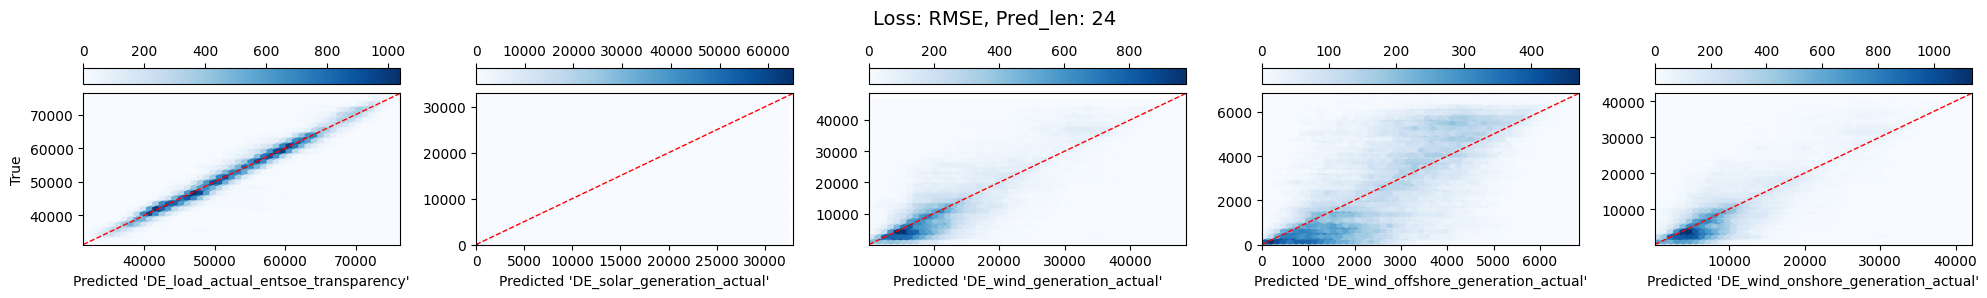

----------------------------------------------------------------------------------------------------------------------------------------------------------------
load actual          min value: 31599.29   max value: 75551.00  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 47825.69  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 42122.91  


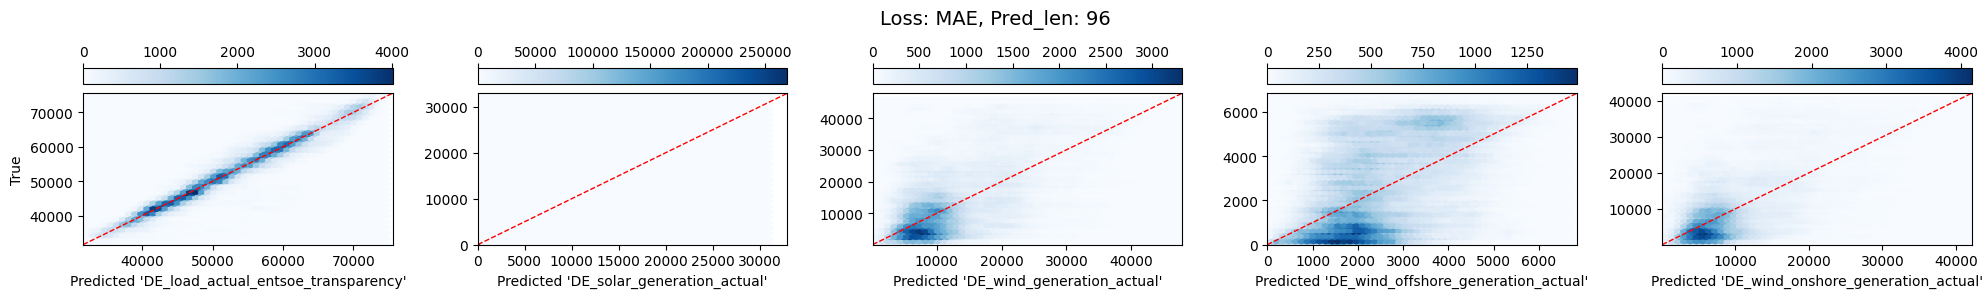

load actual          min value: 31307.00   max value: 75780.16  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 136.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


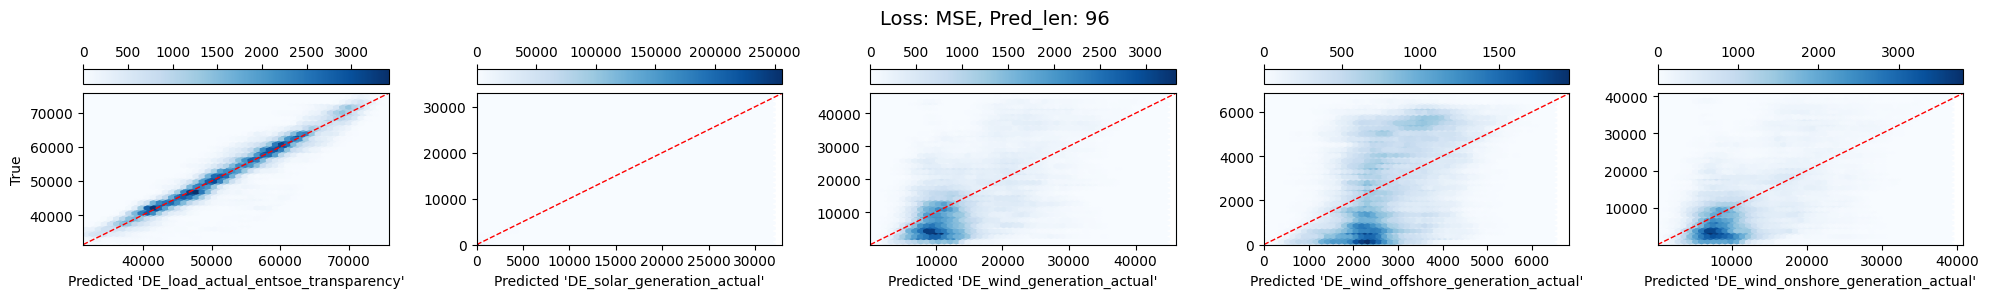

load actual          min value: 31307.00   max value: 75716.78  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


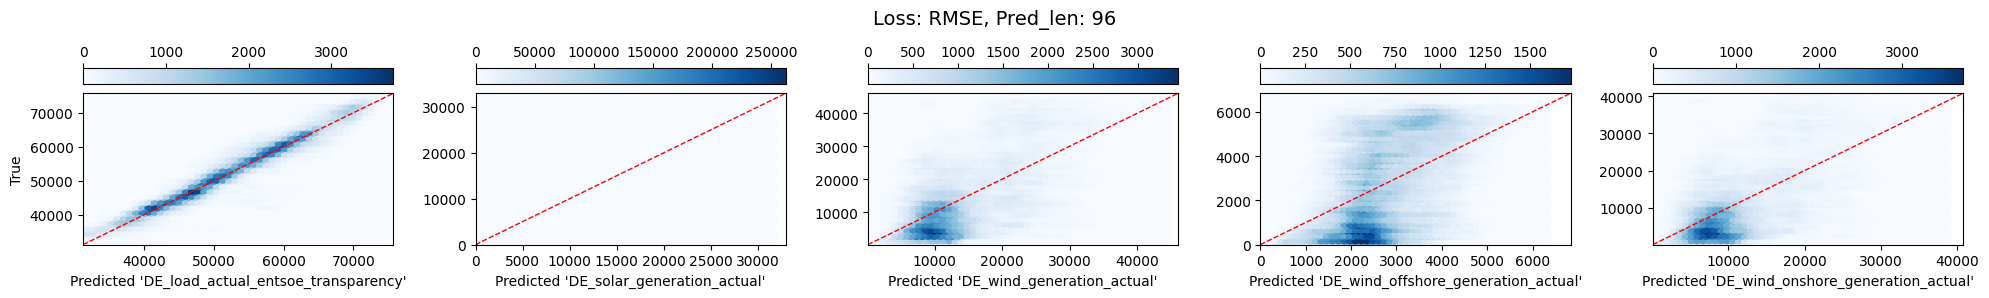

----------------------------------------------------------------------------------------------------------------------------------------------------------------
load actual          min value: 31602.87   max value: 75794.73  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 48126.36  
wind offshore        min value: 0.00       max value: 6923.22   
wind onshore         min value: 119.00     max value: 41954.62  


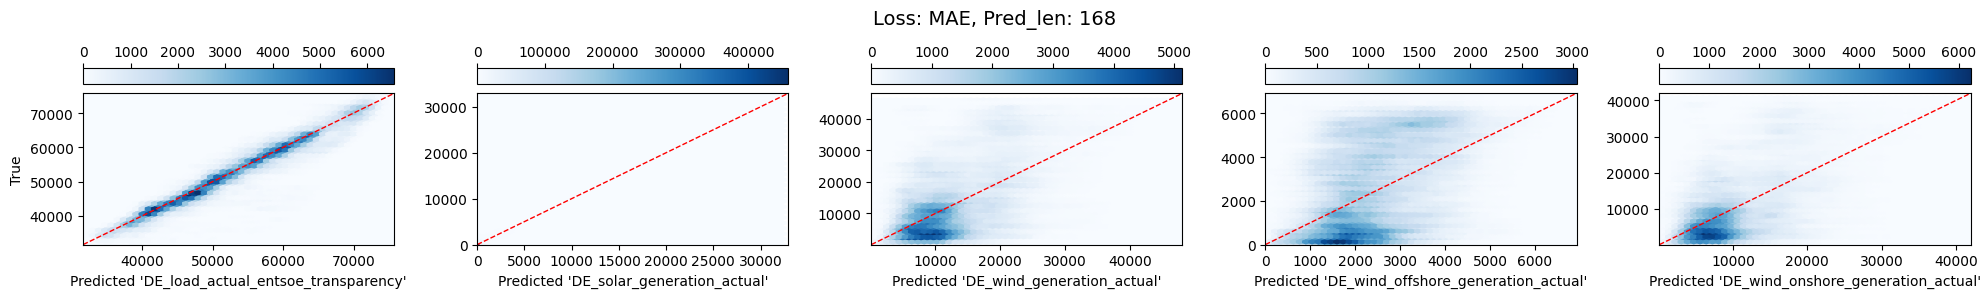

load actual          min value: 31307.00   max value: 75551.00  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


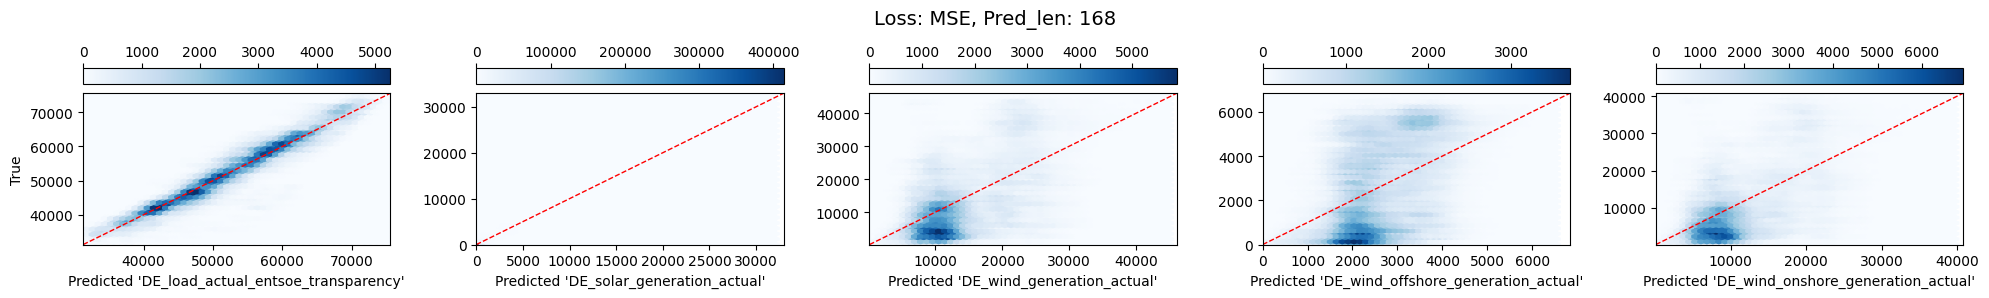

load actual          min value: 31307.00   max value: 75818.14  
solar generation     min value: 0.00       max value: 32947.00  
wind generation      min value: 135.00     max value: 46064.00  
wind offshore        min value: 0.00       max value: 6840.00   
wind onshore         min value: 119.00     max value: 40752.00  


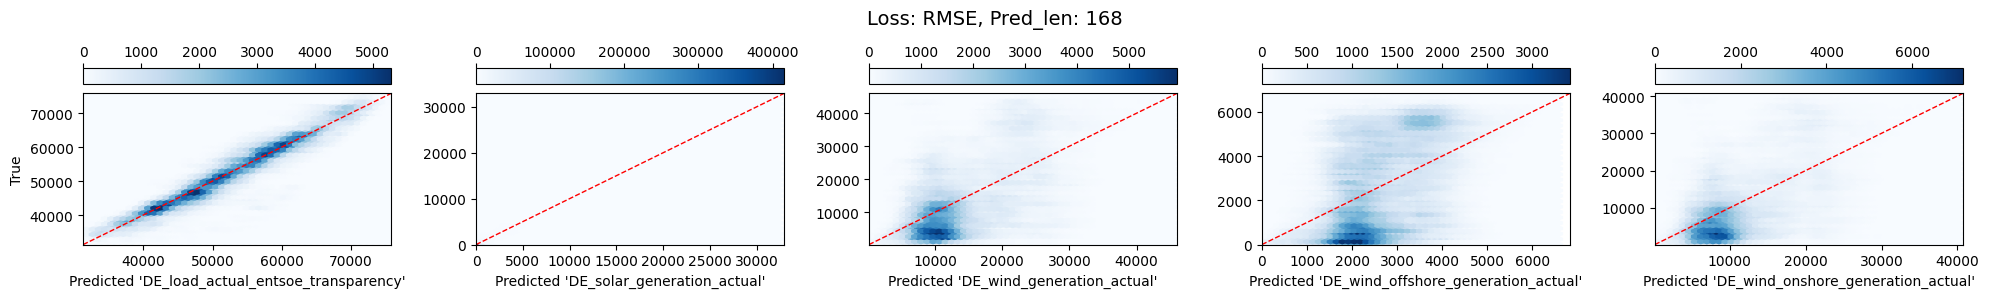

----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [15]:
# Extract columns
cols = pd.read_csv("datasets/DE_data.csv").columns[1:]

#color_maps = ["Blues", "Oranges", "Greens"]
color_maps = ["Blues"]*3 # So easier to compare

# Plots
for pred_len in [24, 96, 168]:
    for i, loss in enumerate(["MAE", "MSE", "RMSE"]):
        plot_error_results("PatchTST", loss, seq_len=512, pred_len=pred_len, itr=2, columns=cols, color=color_maps[i])
    print("-"*160)